# **Projeto 1**
## **Alunos**
- Vitor Hugo Meirelles de Macedo
- Patricia Pereira
- André Teixeira
- Rodrigo Diogo

# Mount Drive

Make a 'Mount Drive' to have access to the CSV files used in this Notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import missingno as msno
import sqlalchemy
from sqlalchemy import create_engine, MetaData, Table, inspect
from scipy.stats import boxcox
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score ,silhouette_score, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV,\
    KFold, StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import recall_score, f1_score, classification_report,\
    confusion_matrix, roc_curve, roc_auc_score, make_scorer, precision_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

# Modeling

## K-Means: Customer Segmentation

### Data Extraction

In [4]:
 # Substitute the file path below with your own file path from 'FINAL-GRUPOIII' folder.
 # The file name is "cust_seg_kmeans_df.csv".
kmeans_df = pd.read_csv("/content/drive/MyDrive/Projeto1/Samba_Lovers/Project_I/APRESENTAÇÃO/FINAL-GRUPOIII/cust_seg_kmeans_df.csv")
kmeans_df.head()

customer_unique_id  tt_product_qty  avg_installments  \
0  0000f46a3911fa3c0805444483337064               1               8.0   
1  0005e1862207bf6ccc02e4228effd9a0               1               3.0   
2  00115fc7123b5310cf6d3a3aa932699e               1               1.0   
3  0011805441c0d1b68b48002f1d005526               1              10.0   
4  00191a9719ef48ebb5860b130347bf33               1               2.0   

  purch_d_n  purch_wd     pay_type sp_rj_mg_or_other     recency  frequency  \
0     night  weekdays  credit_card       other_state   82.121481          1   
1     night   weekend  credit_card          sp_rj_mg   88.019294          1   
2     night   weekend  credit_card       other_state  130.084306          1   
3       day  weekdays  credit_card       other_state   37.432766          1   
4       day  weekdays  credit_card          sp_rj_mg   42.519329          1   

   monetary_value  
0           69.00  
1          135.00  
2           59.99  
3          269.00  
4           47.90

In [5]:
 # Substitute the file path below with your own file path from 'FINAL-GRUPOIII' folder.
# The file name is "cust_seg_kmeans_boxcox_df.csv"
kmeans_bc_df = pd.read_csv("/content/drive/MyDrive/Projeto1/Samba_Lovers/Project_I/APRESENTAÇÃO/FINAL-GRUPOIII/cust_seg_kmeans_boxcox_df.csv")
kmeans_bc_df.head()

customer_unique_id purch_d_n  purch_wd     pay_type  \
0  0000f46a3911fa3c0805444483337064     night  weekdays  credit_card   
1  0005e1862207bf6ccc02e4228effd9a0     night   weekend  credit_card   
2  00115fc7123b5310cf6d3a3aa932699e     night   weekend  credit_card   
3  0011805441c0d1b68b48002f1d005526       day  weekdays  credit_card   
4  00191a9719ef48ebb5860b130347bf33       day  weekdays  credit_card   

  sp_rj_mg_or_other  tt_product_qty_boxcox  avg_installments_boxcox  \
0       other_state               0.009511                 1.543381   
1          sp_rj_mg               0.009511                 0.936848   
2       other_state               0.009511                 0.009935   
3       other_state               0.009511                 1.658119   
4          sp_rj_mg               0.009511                 0.629236   

   recency_boxcox  frequency_boxcox  monetary_value_boxcox  
0       13.146259          0.007275               3.573460  
1       13.614369          0.007275               4.033738  
2       16.528116          0.007275               3.474250  
3        8.712960          0.007275               4.480754  
4        9.334190          0.007275               3.312261

Note: Only execute cells inside each iteration

### Without Box-Cox Transformation

In [6]:
# Inspect
kmeans_df.head()
kmeans_df.info()
kmeans_df.isna().sum()

# Remove customer_unique_id but preserve the index first
original_index = kmeans_df.index
kmeans_df_i = kmeans_df.drop("customer_unique_id", axis = 1)

# Define seed
seed = 123

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10819 non-null  object 
 1   tt_product_qty      10819 non-null  int64  
 2   avg_installments    10819 non-null  float64
 3   purch_d_n           10819 non-null  object 
 4   purch_wd            10819 non-null  object 
 5   pay_type            10819 non-null  object 
 6   sp_rj_mg_or_other   10819 non-null  object 
 7   recency             10819 non-null  float64
 8   frequency           10819 non-null  int64  
 9   monetary_value      10819 non-null  float64
dtypes: float64(3), int64(2), object(5)
memory usage: 845.4+ KB


Transformations
*   One-hot enconding for categorical features
*   Scale for numerical features

In [7]:
# Select categorical features
kmeans_df_cat = kmeans_df_i.select_dtypes("O")

# Select numerical features
kmeans_df_num = kmeans_df_i.select_dtypes("number")


# One-hot enconding
# drop = "first" to eliminate one of the "dummies" and adress multicollinearity
ohe = OneHotEncoder(drop = "first")

# fit_transform
kmeans_df_cat_ohe = ohe.fit_transform(
    kmeans_df_cat).toarray()

# Transform from array to DataFrame with columns names and index
kmeans_df_cat_ohe = pd.DataFrame(
    kmeans_df_cat_ohe,
    columns = ohe.get_feature_names_out(kmeans_df_cat.columns),
    index = original_index)


# Scale
# MinMax instead of StandardScaler due to the lack of normal distributions
scaler = MinMaxScaler()

# fit_transform
kmeans_df_num_scaler = scaler.fit_transform(
    kmeans_df_num)

# DataFrame
kmeans_df_num_scaler = pd.DataFrame(
    kmeans_df_num_scaler,
    columns = kmeans_df_num.columns,
    index = original_index)


# Concatenate
kmeans_df_transf = pd.concat(
    [kmeans_df_cat_ohe,
    kmeans_df_num_scaler],
    axis = 1)


# Inspect
kmeans_df_transf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   purch_d_n_night             10819 non-null  float64
 1   purch_wd_weekend            10819 non-null  float64
 2   pay_type_boleto             10819 non-null  float64
 3   pay_type_credit_card        10819 non-null  float64
 4   pay_type_debit_card         10819 non-null  float64
 5   pay_type_voucher            10819 non-null  float64
 6   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 7   tt_product_qty              10819 non-null  float64
 8   avg_installments            10819 non-null  float64
 9   recency                     10819 non-null  float64
 10  frequency                   10819 non-null  float64
 11  monetary_value              10819 non-null  float64
dtypes: float64(12)
memory usage: 1014.4 KB


#### Iteration 1: All features

Select relevant features

In [8]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf.copy()

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   purch_d_n_night             10819 non-null  float64
 1   purch_wd_weekend            10819 non-null  float64
 2   pay_type_boleto             10819 non-null  float64
 3   pay_type_credit_card        10819 non-null  float64
 4   pay_type_debit_card         10819 non-null  float64
 5   pay_type_voucher            10819 non-null  float64
 6   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 7   tt_product_qty              10819 non-null  float64
 8   avg_installments            10819 non-null  float64
 9   recency                     10819 non-null  float64
 10  frequency                   10819 non-null  float64
 11  monetary_value              10819 non-null  float64
dtypes: float64(12)
memory usage: 1014.4 KB


Define Number of Clusters



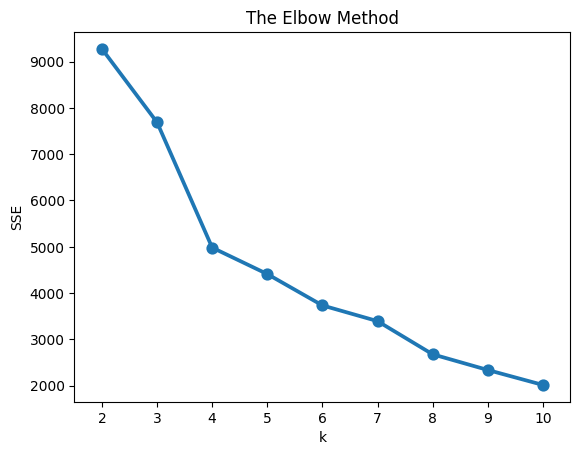

k 2: 0.268
k 3: 0.294
k 4: 0.397
k 5: 0.413
k 6: 0.467
k 7: 0.485
k 8: 0.540
k 9: 0.561
k 10: 0.601


In [9]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [10]:
# Define k
k_final = 10

Running K-Means

In [11]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   purch_d_n_night             10819 non-null  float64
 1   purch_wd_weekend            10819 non-null  float64
 2   pay_type_boleto             10819 non-null  float64
 3   pay_type_credit_card        10819 non-null  float64
 4   pay_type_debit_card         10819 non-null  float64
 5   pay_type_voucher            10819 non-null  float64
 6   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 7   tt_product_qty              10819 non-null  float64
 8   avg_installments            10819 non-null  float64
 9   recency                     10819 non-null  float64
 10  frequency                   10819 non-null  float64
 11  monetary_value              10819 non-null  float64
 12  cluster                     10819 non-null  int32  
dtypes: float64(12), int32(1)
memory

purch_d_n_night  purch_wd_weekend  pay_type_boleto  pay_type_credit_card  \
0              1.0               0.0              0.0                   1.0   
1              1.0               1.0              0.0                   1.0   
2              1.0               1.0              0.0                   1.0   
3              0.0               0.0              0.0                   1.0   
4              0.0               0.0              0.0                   1.0   

   pay_type_debit_card  pay_type_voucher  sp_rj_mg_or_other_sp_rj_mg  \
0                  0.0               0.0                         0.0   
1                  0.0               0.0                         1.0   
2                  0.0               0.0                         0.0   
3                  0.0               0.0                         0.0   
4                  0.0               0.0                         1.0   

   tt_product_qty  avg_installments   recency  frequency  monetary_value  \
0             0.0          0.470588  0.317589        0.0        0.008816   
1             0.0          0.176471  0.340409        0.0        0.017754   
2             0.0          0.058824  0.503170        0.0        0.007596   
3             0.0          0.588235  0.144676        0.0        0.035901   
4             0.0          0.117647  0.164357        0.0        0.005959   

   cluster  
0        5  
1        6  
2        9  
3        0  
4        1

Summary Statistics

In [12]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                            0         1         2         3         4  \
purch_d_n_night             0.000000  0.000000  0.000000  0.000000  1.000000   
purch_wd_weekend            0.000000  0.000000  0.162084  1.000000  0.000000   
pay_type_boleto             0.000000  0.000000  0.934877  0.000000  0.000000   
pay_type_credit_card        1.000000  1.000000  0.000000  0.970149  1.000000   
pay_type_debit_card         0.000000  0.000000  0.021708  0.006219  0.000000   
pay_type_voucher            0.000000  0.000000  0.043415  0.023632  0.000000   
sp_rj_mg_or_other_sp_rj_mg  0.000000  1.000000  0.000000  1.000000  1.000000   
tt_product_qty              0.008139  0.008289  0.011233  0.007818  0.008265   
avg_installments            0.248958  0.212678  0.058824  0.214296  0.209496   
recency                     0.235526  0.243497  0.248314  0.228401  0.240738   
frequency                   0.004529  0.005356  0.007815  0.003731  0.003000   
monetary_value              0.022479  0.

Snake Plot

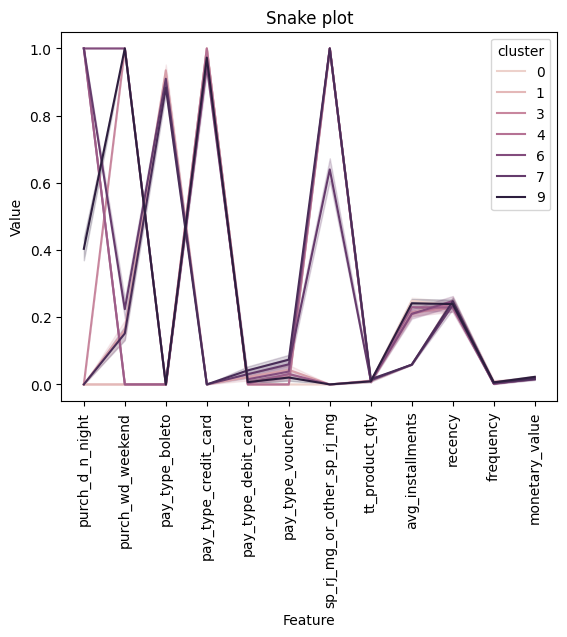

In [13]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 2

Select relevant features

In [14]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["sp_rj_mg_or_other_sp_rj_mg",
                                          "avg_installments",
                                          "tt_product_qty",
                                          "purch_d_n_night",
                                          "purch_wd_weekend",
                                          "pay_type_credit_card",
                                          "recency",
                                          "frequency",
                                          "monetary_value"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   tt_product_qty              10819 non-null  float64
 3   purch_d_n_night             10819 non-null  float64
 4   purch_wd_weekend            10819 non-null  float64
 5   pay_type_credit_card        10819 non-null  float64
 6   recency                     10819 non-null  float64
 7   frequency                   10819 non-null  float64
 8   monetary_value              10819 non-null  float64
dtypes: float64(9)
memory usage: 760.8 KB


Define Number of Clusters



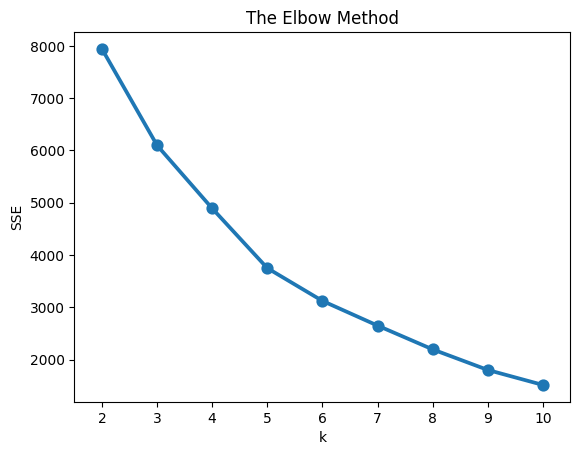

k 2: 0.228
k 3: 0.292
k 4: 0.347
k 5: 0.412
k 6: 0.451
k 7: 0.490
k 8: 0.543
k 9: 0.583
k 10: 0.612


In [15]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [16]:
# Define k
k_final = 5

Running K-Means

In [17]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   tt_product_qty              10819 non-null  float64
 3   purch_d_n_night             10819 non-null  float64
 4   purch_wd_weekend            10819 non-null  float64
 5   pay_type_credit_card        10819 non-null  float64
 6   recency                     10819 non-null  float64
 7   frequency                   10819 non-null  float64
 8   monetary_value              10819 non-null  float64
 9   cluster                     10819 non-null  int32  
dtypes: float64(9), int32(1)
memory usage: 803.1 KB


sp_rj_mg_or_other_sp_rj_mg  avg_installments  tt_product_qty  \
0                         0.0          0.470588             0.0   
1                         1.0          0.176471             0.0   
2                         0.0          0.058824             0.0   
3                         0.0          0.588235             0.0   
4                         1.0          0.117647             0.0   

   purch_d_n_night  purch_wd_weekend  pay_type_credit_card   recency  \
0              1.0               0.0                   1.0  0.317589   
1              1.0               1.0                   1.0  0.340409   
2              1.0               1.0                   1.0  0.503170   
3              0.0               0.0                   1.0  0.144676   
4              0.0               0.0                   1.0  0.164357   

   frequency  monetary_value  cluster  
0        0.0        0.008816        0  
1        0.0        0.017754        2  
2        0.0        0.007596        2  
3        0.0        0.035901        0  
4        0.0        0.005959        4

Summary Statistics

In [18]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                            0         1         2         3         4
sp_rj_mg_or_other_sp_rj_mg  0.000000  0.887408  0.619534  0.615090  1.000000
avg_installments            0.244274  0.155763  0.222861  0.058791  0.212678
tt_product_qty              0.008070  0.010636  0.007404  0.014294  0.008289
purch_d_n_night             0.360878  1.000000  0.415452  0.000000  0.000000
purch_wd_weekend            0.000000  0.063879  1.000000  0.172772  0.000000
pay_type_credit_card        1.000000  0.643382  0.965015  0.000000  1.000000
recency                     0.233047  0.238115  0.237957  0.247688  0.243497
frequency                   0.003548  0.003401  0.003887  0.006670  0.005356
monetary_value              0.022206  0.017625  0.019932  0.017279  0.018797


cluster                       0            1            2          3  \
recency               60.272083    61.581893     61.54087  64.055784   
frequency               1.01774     1.017004     1.019436   1.033352   
monetary_val

Snake Plot

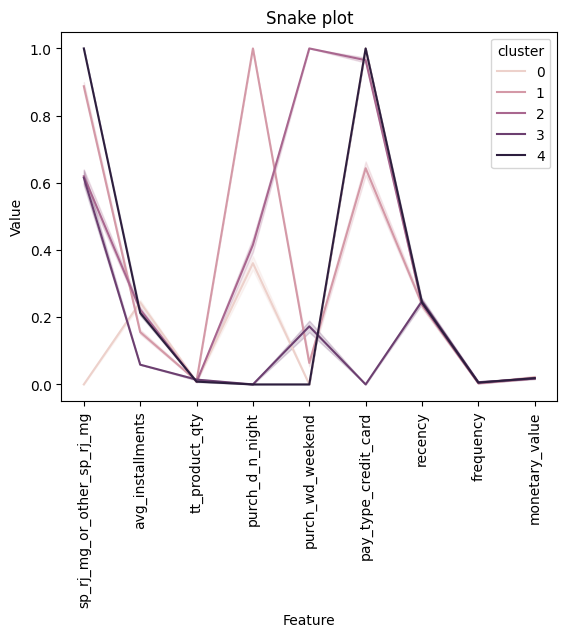

In [19]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 3

Select relevant features

In [20]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["sp_rj_mg_or_other_sp_rj_mg",
                                          "avg_installments",
                                          "tt_product_qty",
                                          "purch_d_n_night",
                                          "purch_wd_weekend",
                                          "pay_type_credit_card",
                                          "recency",
                                          "frequency",
                                          "monetary_value"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   tt_product_qty              10819 non-null  float64
 3   purch_d_n_night             10819 non-null  float64
 4   purch_wd_weekend            10819 non-null  float64
 5   pay_type_credit_card        10819 non-null  float64
 6   recency                     10819 non-null  float64
 7   frequency                   10819 non-null  float64
 8   monetary_value              10819 non-null  float64
dtypes: float64(9)
memory usage: 760.8 KB


Define Number of Clusters



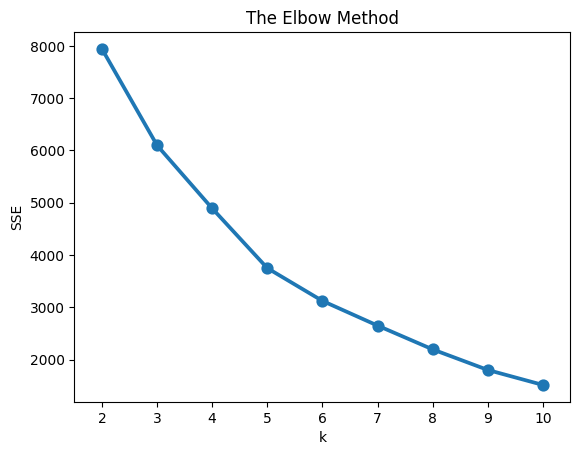

k 2: 0.228
k 3: 0.292
k 4: 0.347
k 5: 0.412
k 6: 0.451
k 7: 0.490
k 8: 0.543
k 9: 0.583
k 10: 0.612


In [21]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [22]:
# Define k
k_final = 5

Running K-Means

In [23]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   tt_product_qty              10819 non-null  float64
 3   purch_d_n_night             10819 non-null  float64
 4   purch_wd_weekend            10819 non-null  float64
 5   pay_type_credit_card        10819 non-null  float64
 6   recency                     10819 non-null  float64
 7   frequency                   10819 non-null  float64
 8   monetary_value              10819 non-null  float64
 9   cluster                     10819 non-null  int32  
dtypes: float64(9), int32(1)
memory usage: 803.1 KB


sp_rj_mg_or_other_sp_rj_mg  avg_installments  tt_product_qty  \
0                         0.0          0.470588             0.0   
1                         1.0          0.176471             0.0   
2                         0.0          0.058824             0.0   
3                         0.0          0.588235             0.0   
4                         1.0          0.117647             0.0   

   purch_d_n_night  purch_wd_weekend  pay_type_credit_card   recency  \
0              1.0               0.0                   1.0  0.317589   
1              1.0               1.0                   1.0  0.340409   
2              1.0               1.0                   1.0  0.503170   
3              0.0               0.0                   1.0  0.144676   
4              0.0               0.0                   1.0  0.164357   

   frequency  monetary_value  cluster  
0        0.0        0.008816        0  
1        0.0        0.017754        2  
2        0.0        0.007596        2  
3        0.0        0.035901        0  
4        0.0        0.005959        4

Summary Statistics

In [24]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                            0         1         2         3         4
sp_rj_mg_or_other_sp_rj_mg  0.000000  0.887408  0.619534  0.615090  1.000000
avg_installments            0.244274  0.155763  0.222861  0.058791  0.212678
tt_product_qty              0.008070  0.010636  0.007404  0.014294  0.008289
purch_d_n_night             0.360878  1.000000  0.415452  0.000000  0.000000
purch_wd_weekend            0.000000  0.063879  1.000000  0.172772  0.000000
pay_type_credit_card        1.000000  0.643382  0.965015  0.000000  1.000000
recency                     0.233047  0.238115  0.237957  0.247688  0.243497
frequency                   0.003548  0.003401  0.003887  0.006670  0.005356
monetary_value              0.022206  0.017625  0.019932  0.017279  0.018797


cluster                       0            1            2          3  \
recency               60.272083    61.581893     61.54087  64.055784   
frequency               1.01774     1.017004     1.019436   1.033352   
monetary_val

Snake Plot

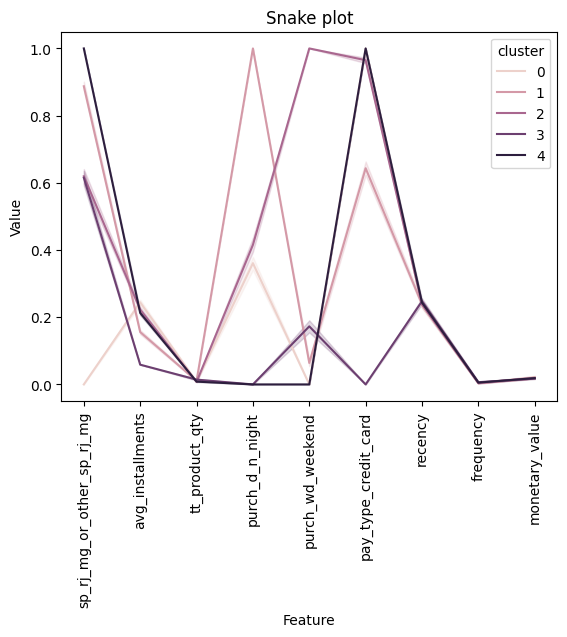

In [25]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 4

Select relevant features

In [26]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["sp_rj_mg_or_other_sp_rj_mg",
                                          "avg_installments",
                                          "tt_product_qty",
                                          "purch_d_n_night",
                                          "purch_wd_weekend",
                                          "pay_type_credit_card",
                                          "pay_type_boleto",
                                          "pay_type_debit_card",
                                          "pay_type_voucher"
                                          ]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   tt_product_qty              10819 non-null  float64
 3   purch_d_n_night             10819 non-null  float64
 4   purch_wd_weekend            10819 non-null  float64
 5   pay_type_credit_card        10819 non-null  float64
 6   pay_type_boleto             10819 non-null  float64
 7   pay_type_debit_card         10819 non-null  float64
 8   pay_type_voucher            10819 non-null  float64
dtypes: float64(9)
memory usage: 760.8 KB


Define Number of Clusters



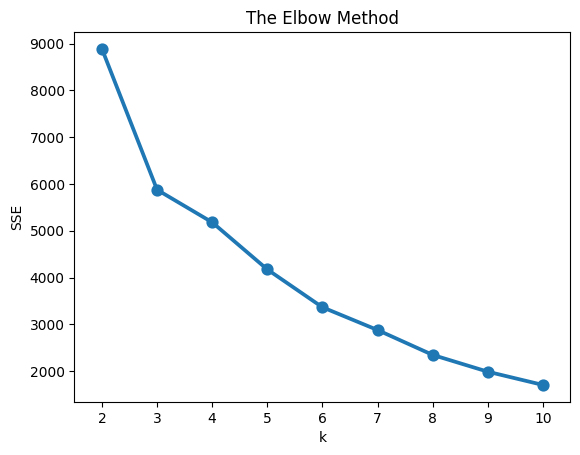

k 2: 0.289
k 3: 0.386
k 4: 0.390
k 5: 0.473
k 6: 0.544
k 7: 0.588
k 8: 0.606
k 9: 0.648
k 10: 0.687


In [27]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [28]:
# Define k
k_final = 5

Running K-Means

In [29]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   tt_product_qty              10819 non-null  float64
 3   purch_d_n_night             10819 non-null  float64
 4   purch_wd_weekend            10819 non-null  float64
 5   pay_type_credit_card        10819 non-null  float64
 6   pay_type_boleto             10819 non-null  float64
 7   pay_type_debit_card         10819 non-null  float64
 8   pay_type_voucher            10819 non-null  float64
 9   cluster                     10819 non-null  int32  
dtypes: float64(9), int32(1)
memory usage: 803.1 KB


sp_rj_mg_or_other_sp_rj_mg  avg_installments  tt_product_qty  \
0                         0.0          0.470588             0.0   
1                         1.0          0.176471             0.0   
2                         0.0          0.058824             0.0   
3                         0.0          0.588235             0.0   
4                         1.0          0.117647             0.0   

   purch_d_n_night  purch_wd_weekend  pay_type_credit_card  pay_type_boleto  \
0              1.0               0.0                   1.0              0.0   
1              1.0               1.0                   1.0              0.0   
2              1.0               1.0                   1.0              0.0   
3              0.0               0.0                   1.0              0.0   
4              0.0               0.0                   1.0              0.0   

   pay_type_debit_card  pay_type_voucher  cluster  
0                  0.0               0.0        3  
1                  0.0               0.0        4  
2                  0.0               0.0        3  
3                  0.0               0.0        0  
4                  0.0               0.0        1

Summary Statistics

In [30]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                            0         1         2         3         4
sp_rj_mg_or_other_sp_rj_mg  0.000000  1.000000  0.601971  0.000000  1.000000
avg_installments            0.243657  0.205475  0.058824  0.231265  0.207144
tt_product_qty              0.008623  0.010837  0.008426  0.009959  0.009735
purch_d_n_night             0.000000  0.000000  0.306341  1.000000  0.712652
purch_wd_weekend            0.235676  0.000000  0.194944  0.269406  0.474267
pay_type_credit_card        0.968649  0.953319  0.000000  0.968950  0.956040
pay_type_boleto             0.000000  0.000000  1.000000  0.000000  0.000000
pay_type_debit_card         0.010270  0.016776  0.000000  0.002740  0.013224
pay_type_voucher            0.021081  0.029540  0.000000  0.028311  0.030736


cluster                       0            1           2            3  \
recency               60.886033    62.956893   63.282862    60.522123   
frequency              1.024324     1.027717    1.027421     1.014612   
monetary_

Snake Plot

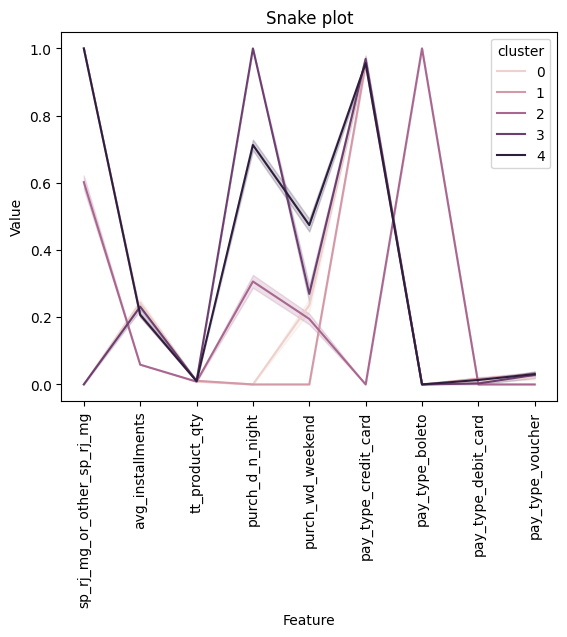

In [31]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 5

Select relevant features

In [32]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["sp_rj_mg_or_other_sp_rj_mg",
                                          "avg_installments",
                                          "purch_d_n_night",
                                          "purch_wd_weekend",
                                          "recency",
                                          "monetary_value"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   purch_d_n_night             10819 non-null  float64
 3   purch_wd_weekend            10819 non-null  float64
 4   recency                     10819 non-null  float64
 5   monetary_value              10819 non-null  float64
dtypes: float64(6)
memory usage: 507.3 KB


Define Number of Clusters



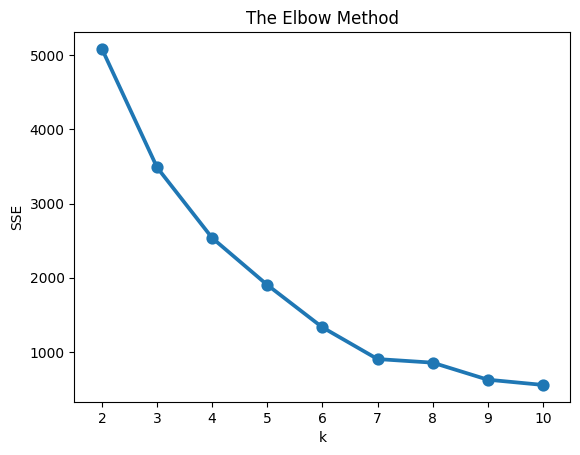

k 2: 0.379
k 3: 0.448
k 4: 0.513
k 5: 0.565
k 6: 0.632
k 7: 0.688
k 8: 0.638
k 9: 0.669
k 10: 0.576


In [33]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [34]:
# Define k
k_final = 3

Running K-Means

In [35]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   purch_d_n_night             10819 non-null  float64
 3   purch_wd_weekend            10819 non-null  float64
 4   recency                     10819 non-null  float64
 5   monetary_value              10819 non-null  float64
 6   cluster                     10819 non-null  int32  
dtypes: float64(6), int32(1)
memory usage: 549.5 KB


sp_rj_mg_or_other_sp_rj_mg  avg_installments  purch_d_n_night  \
0                         0.0          0.470588              1.0   
1                         1.0          0.176471              1.0   
2                         0.0          0.058824              1.0   
3                         0.0          0.588235              0.0   
4                         1.0          0.117647              0.0   

   purch_wd_weekend   recency  monetary_value  cluster  
0               0.0  0.317589        0.008816        0  
1               1.0  0.340409        0.017754        1  
2               1.0  0.503170        0.007596        0  
3               0.0  0.144676        0.035901        0  
4               0.0  0.164357        0.005959        2

Summary Statistics

In [36]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                            0         1         2
sp_rj_mg_or_other_sp_rj_mg  0.000000  1.000000  1.000000
avg_installments            0.195830  0.178362  0.175468
purch_d_n_night             0.355705  1.000000  0.000000
purch_wd_weekend            0.234383  0.261336  0.214871
recency                     0.237252  0.241064  0.241786
monetary_value              0.020941  0.017706  0.018499


cluster                       0            1            2
recency               61.358675    62.343978    62.530464
frequency              1.022974     1.016488     1.025891
monetary_value       158.531242   134.645111   140.495784
tt_product_qty         1.188952     1.204452     1.209117
avg_installments       3.329117     3.032152     2.982961
sp_rj_mg_or_other   other_state     sp_rj_mg     sp_rj_mg
purch_d_n                   day        night          day
purch_wd               weekdays     weekdays     weekdays
pay_type            credit_card  credit_card  credit_card
customer_unique_id 

Snake Plot

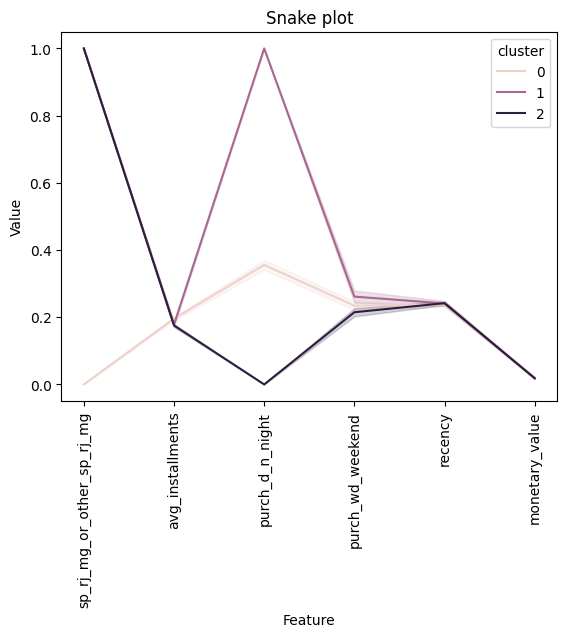

In [37]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 6

Select relevant features

In [38]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["sp_rj_mg_or_other_sp_rj_mg",
                                          "avg_installments",
                                          "recency",
                                          "monetary_value"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   recency                     10819 non-null  float64
 3   monetary_value              10819 non-null  float64
dtypes: float64(4)
memory usage: 338.2 KB


Define Number of Clusters



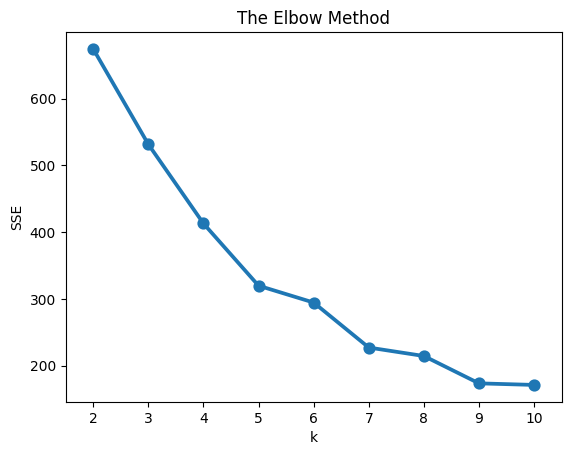

k 2: 0.720
k 3: 0.537
k 4: 0.539
k 5: 0.445
k 6: 0.438
k 7: 0.443
k 8: 0.418
k 9: 0.422
k 10: 0.400


In [39]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [40]:
# Define k
k_final = 3

Running K-Means

In [41]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   recency                     10819 non-null  float64
 3   monetary_value              10819 non-null  float64
 4   cluster                     10819 non-null  int32  
dtypes: float64(4), int32(1)
memory usage: 380.5 KB


sp_rj_mg_or_other_sp_rj_mg  avg_installments   recency  monetary_value  \
0                         0.0          0.470588  0.317589        0.008816   
1                         1.0          0.176471  0.340409        0.017754   
2                         0.0          0.058824  0.503170        0.007596   
3                         0.0          0.588235  0.144676        0.035901   
4                         1.0          0.117647  0.164357        0.005959   

   cluster  
0        0  
1        1  
2        0  
3        0  
4        1

Summary Statistics

In [42]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                            0         1         2
sp_rj_mg_or_other_sp_rj_mg  0.000000  1.000000  1.000000
avg_installments            0.195830  0.099568  0.442631
recency                     0.237252  0.245423  0.228074
monetary_value              0.020941  0.014054  0.032643


cluster                       0            1            2
recency               61.358675    63.470527    58.986809
frequency              1.022974     1.021158     1.027617
monetary_value       158.531242   107.679657   244.939949
tt_product_qty         1.188952     1.196919     1.244059
avg_installments       3.329117      1.69265     7.524727
sp_rj_mg_or_other   other_state     sp_rj_mg     sp_rj_mg
purch_d_n                   day          day          day
purch_wd               weekdays     weekdays     weekdays
pay_type            credit_card  credit_card  credit_card
customer_unique_id         3874         5388         1557


Snake Plot

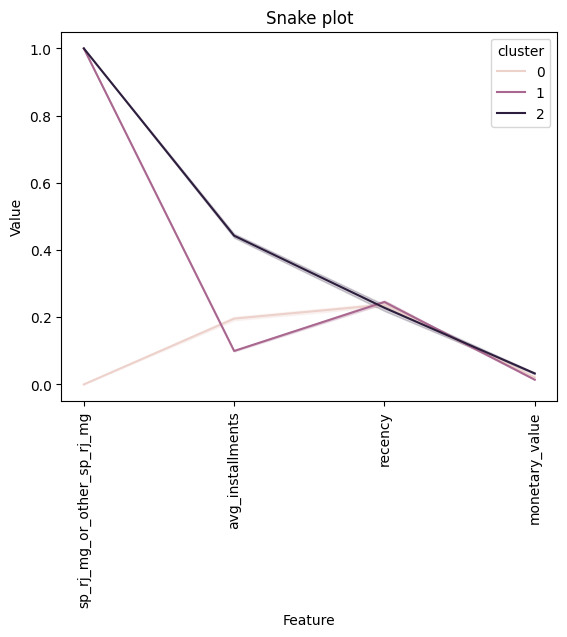

In [43]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 7 (better)

Select relevant features

In [44]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["avg_installments",
                                          "recency"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avg_installments  10819 non-null  float64
 1   recency           10819 non-null  float64
dtypes: float64(2)
memory usage: 169.2 KB


Define Number of Clusters



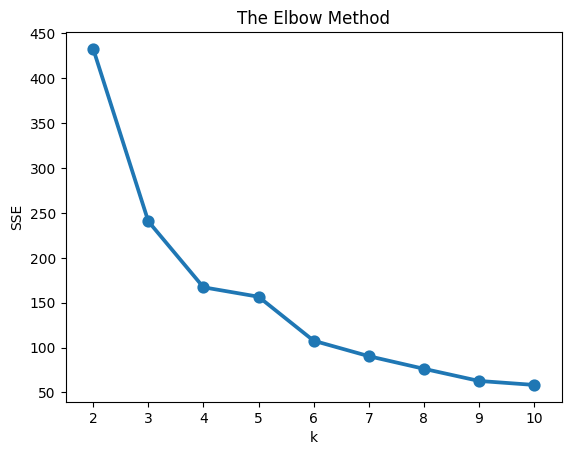

k 2: 0.372
k 3: 0.459
k 4: 0.484
k 5: 0.413
k 6: 0.430
k 7: 0.443
k 8: 0.430
k 9: 0.451
k 10: 0.449


In [45]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [46]:
# Define k
k_final = 4

Running K-Means

In [47]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avg_installments  10819 non-null  float64
 1   recency           10819 non-null  float64
 2   cluster           10819 non-null  int32  
dtypes: float64(2), int32(1)
memory usage: 211.4 KB


avg_installments   recency  cluster
0          0.470588  0.317589        2
1          0.176471  0.340409        3
2          0.058824  0.503170        3
3          0.588235  0.144676        2
4          0.117647  0.164357        1

Summary Statistics

In [48]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                  0         1         2         3
avg_installments  0.212393  0.115091  0.480156  0.107752
recency           0.916630  0.103721  0.204989  0.368285


cluster                       0            1            2            3
recency              236.941825    26.847971    53.020493    95.223828
frequency               1.01145      1.02206     1.030467     1.020306
monetary_value       154.382366   114.214836   279.063843   112.715109
tt_product_qty         1.263359     1.177587     1.241769     1.202306
avg_installments       3.610687     1.956541     8.162654     1.831787
sp_rj_mg_or_other      sp_rj_mg     sp_rj_mg     sp_rj_mg     sp_rj_mg
purch_d_n                   day          day          day          day
purch_wd               weekdays     weekdays     weekdays     weekdays
pay_type            credit_card  credit_card  credit_card  credit_card
customer_unique_id          262         4533         2035         3989


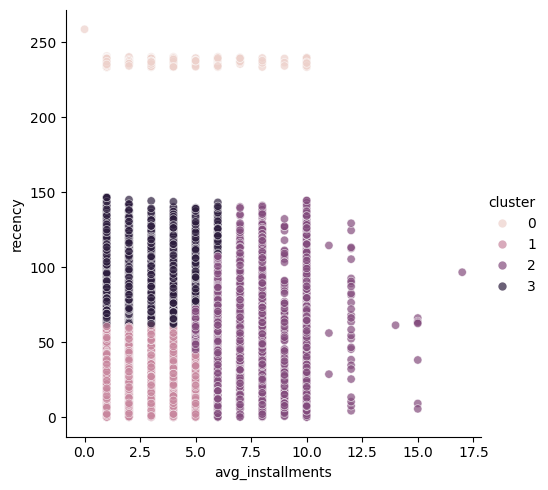

In [49]:
sns.relplot(
    data = kmeans_df_final,
    x = "avg_installments",
    y = "recency",
    hue = "cluster",
    alpha = 0.7
)
plt.show()

Snake Plot

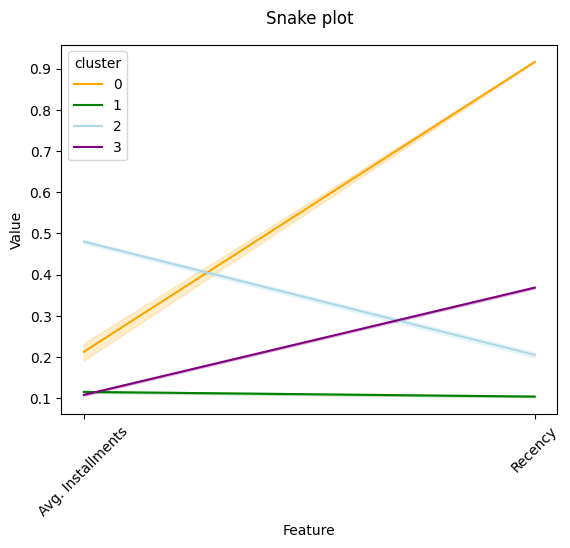

In [50]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

kmeans_df_transf_iter_final_melt["Feature"] = kmeans_df_transf_iter_final_melt[
    "Feature"].map(
        {"avg_installments": "Avg. Installments",
         "recency": "Recency"})

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster',
             palette = ["orange", "green", "lightblue", "purple"])
plt.title('Snake plot', pad = 15)
plt.xticks(rotation = 45)
plt.show()


Define this iteration as final version for export as csv

In [51]:
kmeans_df_final.info()
kmeans_df_final.nunique()

kmeans_df_final.to_csv("clusters.csv", index = False) # Don't use this csv file. Use the csv file from the drive.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10819 non-null  object 
 1   tt_product_qty      10819 non-null  int64  
 2   avg_installments    10819 non-null  float64
 3   purch_d_n           10819 non-null  object 
 4   purch_wd            10819 non-null  object 
 5   pay_type            10819 non-null  object 
 6   sp_rj_mg_or_other   10819 non-null  object 
 7   recency             10819 non-null  float64
 8   frequency           10819 non-null  int64  
 9   monetary_value      10819 non-null  float64
 10  cluster             10819 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(5)
memory usage: 887.6+ KB


#### Iteration 7.1 (different number of k)

Select relevant features

In [52]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["avg_installments",
                                          "recency",
                                          "monetary_value"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avg_installments  10819 non-null  float64
 1   recency           10819 non-null  float64
 2   monetary_value    10819 non-null  float64
dtypes: float64(3)
memory usage: 253.7 KB


Define Number of Clusters



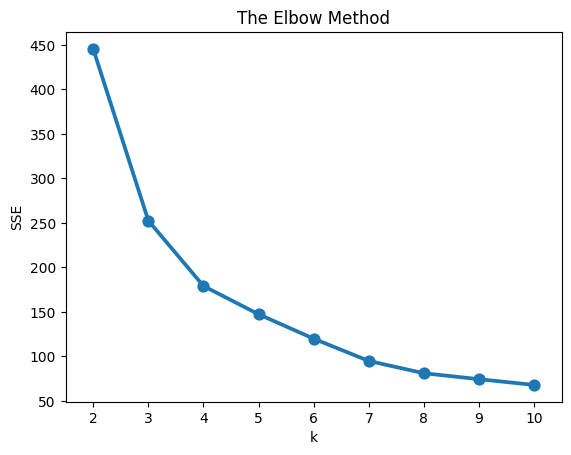

k 2: 0.366
k 3: 0.450
k 4: 0.473
k 5: 0.463
k 6: 0.407
k 7: 0.434
k 8: 0.444
k 9: 0.446
k 10: 0.411


In [53]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [54]:
# Define k
k_final = 4

Running K-Means

In [55]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   avg_installments  10819 non-null  float64
 1   recency           10819 non-null  float64
 2   monetary_value    10819 non-null  float64
 3   cluster           10819 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 296.0 KB


avg_installments   recency  monetary_value  cluster
0          0.470588  0.317589        0.008816        2
1          0.176471  0.340409        0.017754        3
2          0.058824  0.503170        0.007596        3
3          0.588235  0.144676        0.035901        2
4          0.117647  0.164357        0.005959        1

Summary Statistics

In [56]:
# Profile and Interpret Segmentation
clus_info = kmeans_df_transf_iter_final.groupby("cluster").agg("mean")
print(clus_info.T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                  0         1         2         3
avg_installments  0.212393  0.115076  0.479849  0.107558
recency           0.916630  0.103658  0.205209  0.368208
monetary_value    0.020379  0.014897  0.037451  0.014668


cluster                       0            1            2            3
recency              236.941825    26.831797    53.077445    95.203977
frequency               1.01145     1.022075     1.030407     1.020311
monetary_value       154.382366   113.897587   280.438269   112.207031
tt_product_qty         1.263359     1.177704     1.242276     1.201856
avg_installments       3.610687     1.956291      8.15743     1.828485
sp_rj_mg_or_other      sp_rj_mg     sp_rj_mg     sp_rj_mg     sp_rj_mg
purch_d_n                   day          day          day          day
purch_wd               weekdays     weekdays     weekdays     weekdays
pay_type            credit_card  credit_card  credit_card  credit_card
customer_unique_id          262         4530         2039   

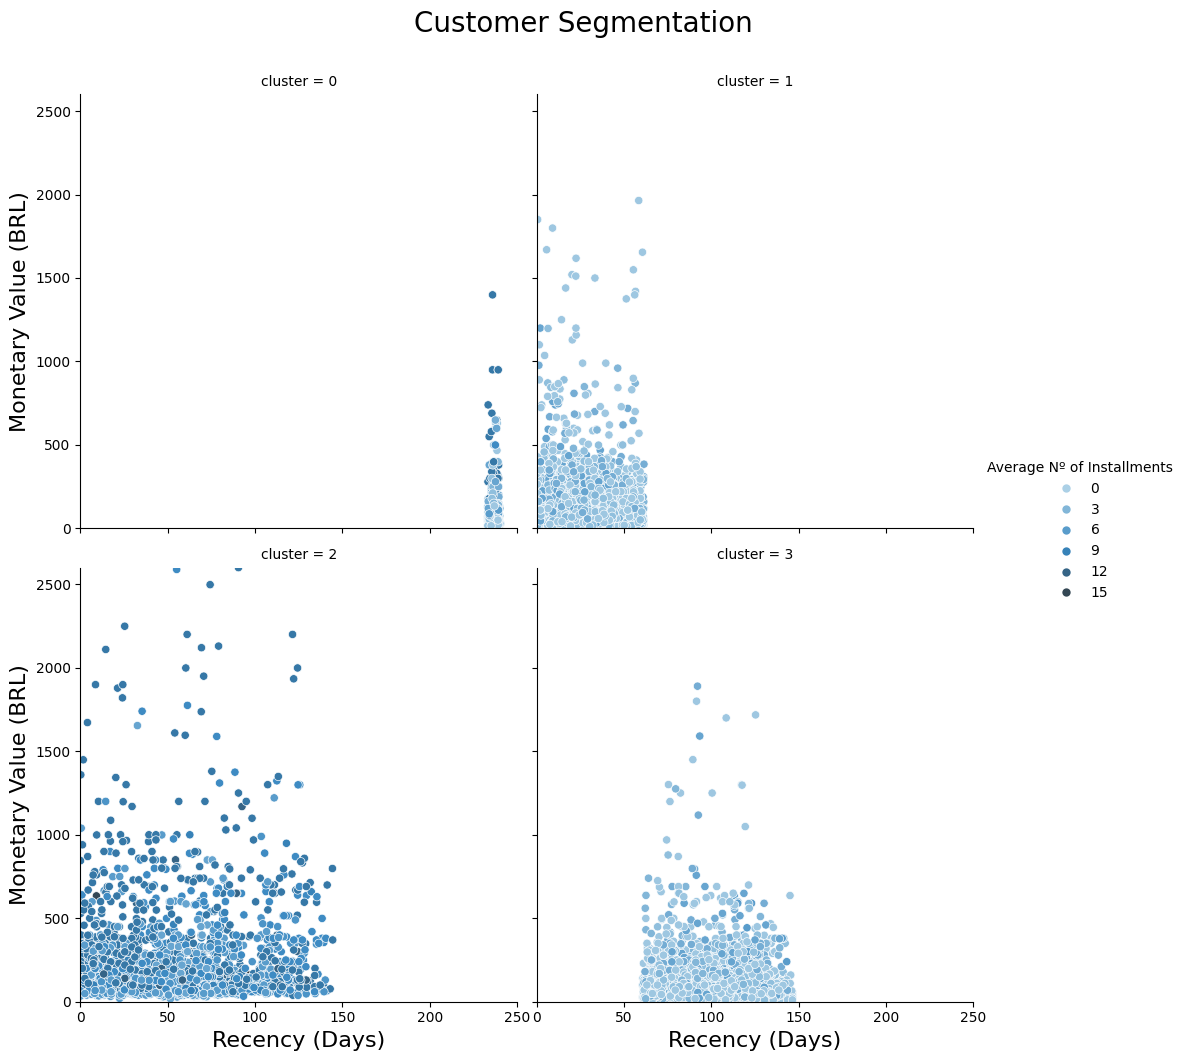

In [57]:
kmeans_df_final_name = kmeans_df_final.rename({"avg_installments": "Average Nº of Installments"}, axis = 1)

g = sns.relplot(
    data = kmeans_df_final_name,
    x = "recency",
    y = "monetary_value",
    hue = "Average Nº of Installments",
    col = "cluster",
    col_wrap = 2,
    palette = "Blues_d"
)
g.set(ylim = (0, 2600), xlim = (0, 250))
g.set_axis_labels("Recency (Days)", "Monetary Value (BRL)", fontsize = 16)
g.fig.suptitle("Customer Segmentation", fontsize = 20, y = 1.05)
plt.show()

<ipython-input-58-e40b771fb6f0>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


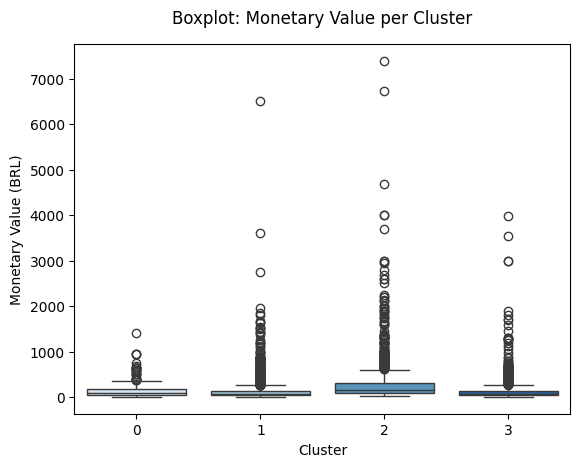

In [58]:
sns.boxplot(
    data = kmeans_df_final,
    x = "cluster",
    y = "monetary_value",
    palette = "Blues"
)
plt.title("Boxplot: Monetary Value per Cluster", pad = 15)
plt.ylabel("Monetary Value (BRL)")
plt.xlabel("Cluster")
plt.show()

In [59]:
kmeans_df_final.groupby("cluster")[["recency", "monetary_value", "avg_installments"]].agg([
    "min", np.mean, np.median, "max", "count"
]).round(2).T

<ipython-input-59-2baeeb488e21>:1: FutureWarning: The provided callable <function mean at 0x7cf3179bd300> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  kmeans_df_final.groupby("cluster")[["recency", "monetary_value", "avg_installments"]].agg([
<ipython-input-59-2baeeb488e21>:1: FutureWarning: The provided callable <function median at 0x7cf314c22980> is currently using SeriesGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  kmeans_df_final.groupby("cluster")[["recency", "monetary_value", "avg_installments"]].agg([


cluster                        0        1        2        3
recency          min      233.24     0.04     0.06    60.58
                 mean     236.94    26.83    53.08    95.20
                 median   237.16    24.57    49.31    92.12
                 max      258.49    61.41   144.44   146.50
                 count    262.00  4530.00  2039.00  3988.00
monetary_value   min        6.00     4.50    17.46     3.90
                 mean     154.38   113.90   280.44   112.21
                 median    89.90    69.99   159.90    69.90
                 max     1399.00  6499.00  7388.00  3980.00
                 count    262.00  4530.00  2039.00  3988.00
avg_installments min        0.00     1.00     5.00     1.00
                 mean       3.61     1.96     8.16     1.83
                 median     3.00     1.00     8.00     1.00
                 max       10.00     5.00    17.00     6.00
                 count    262.00  4530.00  2039.00  3988.00

Snake Plot

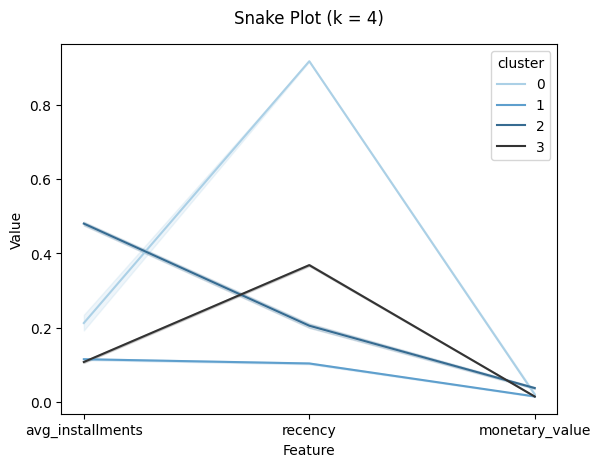

In [60]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster',
             palette = "Blues_d")
plt.title('Snake Plot (k = 4)', pad = 15)
plt.xticks(rotation = 0)
plt.show()


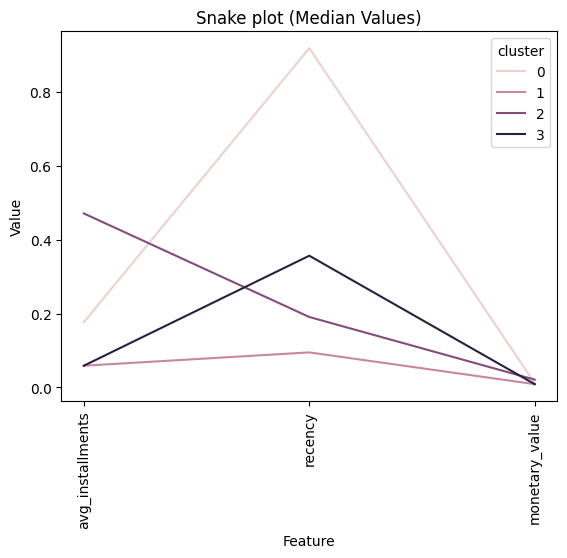

In [61]:
# Calculate median values for each feature within each cluster
kmeans_df_median = kmeans_df_transf_iter_final.groupby("cluster").median().reset_index()

# Melt the data into a long format
kmeans_df_median_melt = pd.melt(
    kmeans_df_median,
    id_vars="cluster",
    var_name="Feature",
    value_name="Value"
)

# Visualize a snake plot
sns.lineplot(
    data=kmeans_df_median_melt,
    x="Feature",
    y="Value",
    hue="cluster"
)

plt.title('Snake plot (Median Values)')
plt.xticks(rotation=90)
plt.show()

In [71]:
kmeans_df_final.info()
kmeans_df_final.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10819 non-null  object 
 1   tt_product_qty      10819 non-null  int64  
 2   avg_installments    10819 non-null  float64
 3   purch_d_n           10819 non-null  object 
 4   purch_wd            10819 non-null  object 
 5   pay_type            10819 non-null  object 
 6   sp_rj_mg_or_other   10819 non-null  object 
 7   recency             10819 non-null  float64
 8   frequency           10819 non-null  int64  
 9   monetary_value      10819 non-null  float64
 10  cluster             10819 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(5)
memory usage: 887.6+ KB


customer_unique_id    10819
tt_product_qty           18
avg_installments         16
purch_d_n                 2
purch_wd                  2
pay_type                  5
sp_rj_mg_or_other         2
recency               10809
frequency                 5
monetary_value         2055
cluster                   3
dtype: int64

#### Iteration 8

Select relevant features

In [63]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["sp_rj_mg_or_other_sp_rj_mg",
                                          "avg_installments",
                                          "recency"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   recency                     10819 non-null  float64
dtypes: float64(3)
memory usage: 253.7 KB


Define Number of Clusters



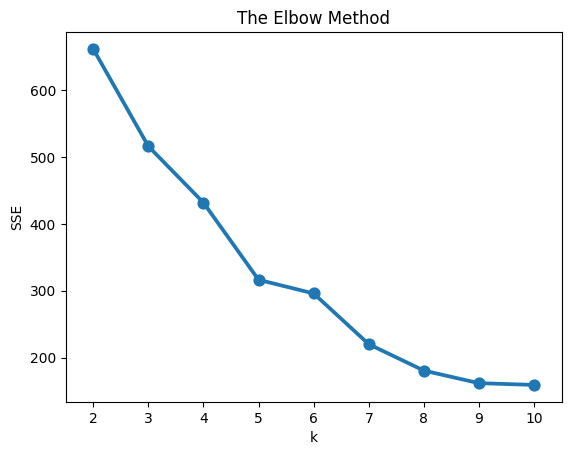

k 2: 0.722
k 3: 0.495
k 4: 0.373
k 5: 0.425
k 6: 0.383
k 7: 0.417
k 8: 0.459
k 9: 0.433
k 10: 0.422


In [64]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [65]:
# Define k
k_final = 3

Running K-Means

In [66]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 4 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 1   avg_installments            10819 non-null  float64
 2   recency                     10819 non-null  float64
 3   cluster                     10819 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 296.0 KB


sp_rj_mg_or_other_sp_rj_mg  avg_installments   recency  cluster
0                         0.0          0.470588  0.317589        0
1                         1.0          0.176471  0.340409        2
2                         0.0          0.058824  0.503170        0
3                         0.0          0.588235  0.144676        0
4                         1.0          0.117647  0.164357        1

Summary Statistics

In [67]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                            0         1         2
sp_rj_mg_or_other_sp_rj_mg  0.000000  1.000000  1.000000
avg_installments            0.195830  0.201194  0.142492
recency                     0.237252  0.120541  0.407919


cluster                       0            1            2
recency               61.358675    31.195222   105.467056
frequency              1.022974     1.024869     1.019494
monetary_value       158.531242   149.267381   123.579121
tt_product_qty         1.188952      1.20194     1.215116
avg_installments       3.329117     3.420293     2.422367
sp_rj_mg_or_other   other_state     sp_rj_mg     sp_rj_mg
purch_d_n                   day          day          day
purch_wd               weekdays     weekdays     weekdays
pay_type            credit_card  credit_card  credit_card
customer_unique_id         3874         4021         2924


Snake Plot

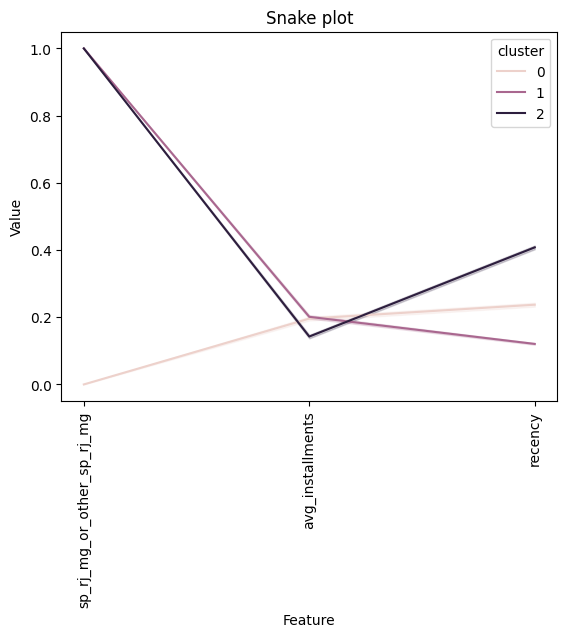

In [68]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 9

Select relevant features

In [69]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["avg_installments",
                                          "recency",
                                          "pay_type_credit_card"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_installments      10819 non-null  float64
 1   recency               10819 non-null  float64
 2   pay_type_credit_card  10819 non-null  float64
dtypes: float64(3)
memory usage: 253.7 KB


Define Number of Clusters



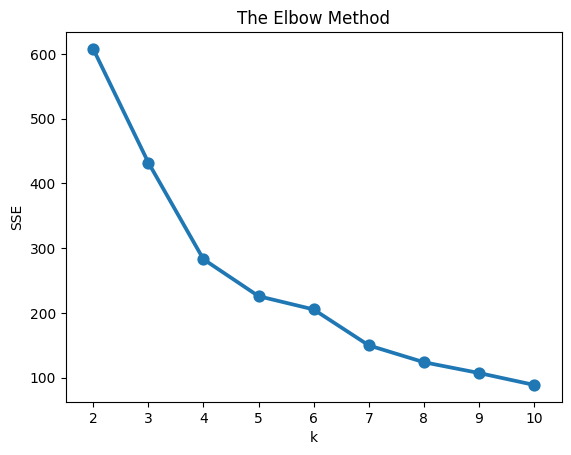

k 2: 0.738
k 3: 0.465
k 4: 0.526
k 5: 0.542
k 6: 0.486
k 7: 0.436
k 8: 0.471
k 9: 0.481
k 10: 0.461


In [70]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [72]:
# Define k
k_final = 5

Running K-Means

In [73]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   avg_installments      10819 non-null  float64
 1   recency               10819 non-null  float64
 2   pay_type_credit_card  10819 non-null  float64
 3   cluster               10819 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 296.0 KB


avg_installments   recency  pay_type_credit_card  cluster
0          0.470588  0.317589                   1.0        3
1          0.176471  0.340409                   1.0        4
2          0.058824  0.503170                   1.0        4
3          0.588235  0.144676                   1.0        3
4          0.117647  0.164357                   1.0        2

Summary Statistics

In [74]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                      0         1         2         3         4
avg_installments      0.257317  0.058802  0.150769  0.502262  0.133875
recency               0.916436  0.243458  0.102242  0.210123  0.366213
pay_type_credit_card  1.000000  0.000000  1.000000  1.000000  1.000000


cluster                       0           1            2            3  \
recency              236.891508   62.962548    26.465846    54.347466   
frequency              1.014778    1.028764     1.020315     1.029759   
monetary_value       164.925567  126.023549   106.715033   296.983251   
tt_product_qty         1.226601    1.304072     1.130079     1.250421   
avg_installments       4.374384    0.999626     2.563069     8.538462   
sp_rj_mg_or_other      sp_rj_mg    sp_rj_mg     sp_rj_mg     sp_rj_mg   
purch_d_n                   day         day          day          day   
purch_wd               weekdays    weekdays     weekdays     weekdays   
pay_type            credit_card      boleto  credit_card 

Snake Plot

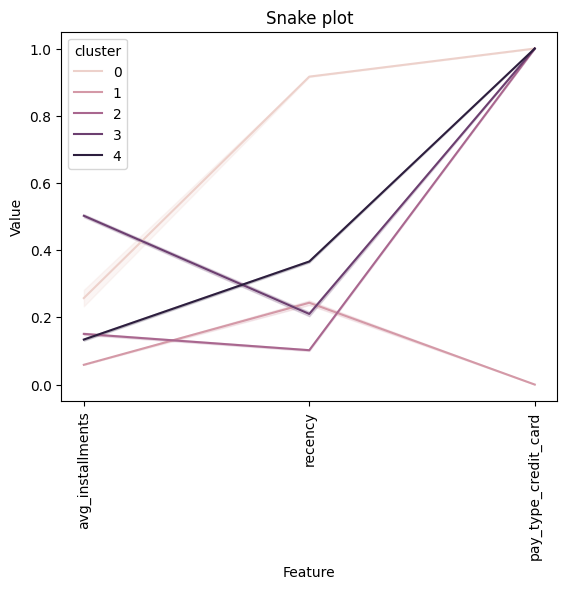

In [75]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 10

Select relevant features

In [76]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_df_transf[["pay_type_credit_card",
                                          "recency",
                                          "monetary_value"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pay_type_credit_card  10819 non-null  float64
 1   recency               10819 non-null  float64
 2   monetary_value        10819 non-null  float64
dtypes: float64(3)
memory usage: 253.7 KB


Define Number of Clusters



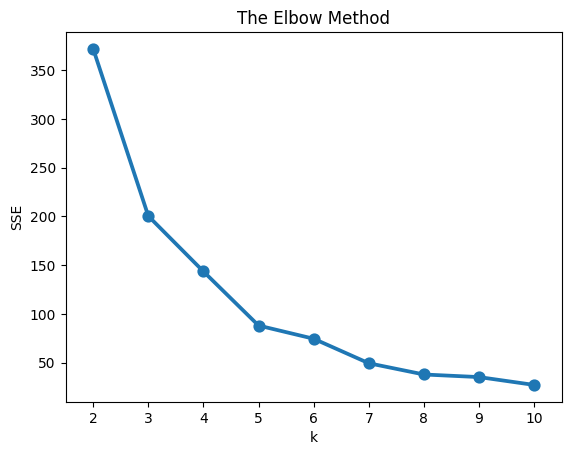

k 2: 0.806
k 3: 0.634
k 4: 0.662
k 5: 0.608
k 6: 0.601
k 7: 0.575
k 8: 0.583
k 9: 0.571
k 10: 0.530


In [77]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [78]:
# Define k
k_final = 4

Running K-Means

In [79]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   pay_type_credit_card  10819 non-null  float64
 1   recency               10819 non-null  float64
 2   monetary_value        10819 non-null  float64
 3   cluster               10819 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 296.0 KB


pay_type_credit_card   recency  monetary_value  cluster
0                   1.0  0.317589        0.008816        0
1                   1.0  0.340409        0.017754        0
2                   1.0  0.503170        0.007596        0
3                   1.0  0.144676        0.035901        2
4                   1.0  0.164357        0.005959        2

Summary Statistics

In [80]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)

print("\n")

print(kmeans_df_final.groupby("cluster").agg({
    "recency": "mean",
    "frequency": "mean",
    "monetary_value": "mean",
    "tt_product_qty": "mean",
    "avg_installments": "mean",
    "sp_rj_mg_or_other": lambda x: x.mode().iloc[0],
    "purch_d_n": lambda x: x.mode().iloc[0],
    "purch_wd": lambda x: x.mode().iloc[0],
    "pay_type": lambda x: x.mode().iloc[0],
    "customer_unique_id": "count"
}).T)


cluster                      0         1         2         3
pay_type_credit_card  1.000000  0.000000  1.000000  1.000000
recency               0.363664  0.243458  0.104097  0.916436
monetary_value        0.020937  0.016539  0.019271  0.021807


cluster                       0           1            2            3
recency               94.029577   62.962548    26.945298   236.891508
frequency              1.017539    1.028764     1.023695     1.014778
monetary_value       158.501069  126.023549    146.19709   164.925567
tt_product_qty          1.17539    1.304072      1.15712     1.226601
avg_installments       3.585746    0.999626     3.977226     4.374384
sp_rj_mg_or_other      sp_rj_mg    sp_rj_mg     sp_rj_mg     sp_rj_mg
purch_d_n                   day         day          day          day
purch_wd               weekdays    weekdays     weekdays     weekdays
pay_type            credit_card      boleto  credit_card  credit_card
customer_unique_id         3592        2677         43

Snake Plot

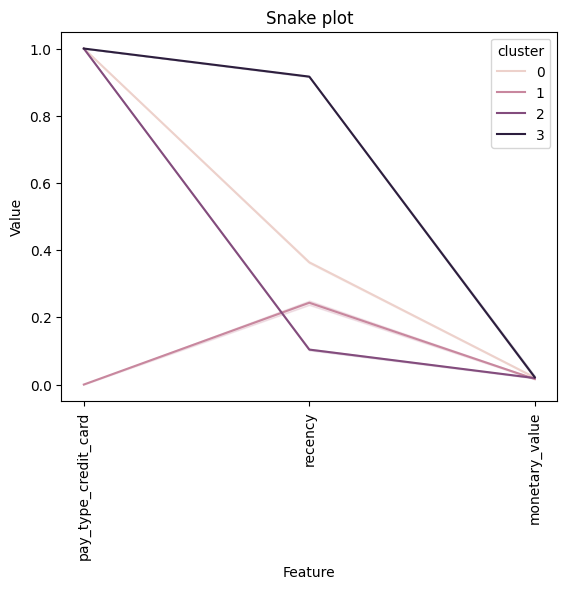

In [81]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


### Box-Cox Transformation

In [82]:
# Inspect
kmeans_bc_df.head()
kmeans_bc_df.info()
kmeans_bc_df.isna().sum()

# Remove customer_unique_id but preserve the index first
original_index_bc = kmeans_bc_df.index
kmeans_bc_df_i = kmeans_bc_df.drop("customer_unique_id", axis = 1)

# Define seed
seed = 123

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_unique_id       10819 non-null  object 
 1   purch_d_n                10819 non-null  object 
 2   purch_wd                 10819 non-null  object 
 3   pay_type                 10819 non-null  object 
 4   sp_rj_mg_or_other        10819 non-null  object 
 5   tt_product_qty_boxcox    10819 non-null  float64
 6   avg_installments_boxcox  10819 non-null  float64
 7   recency_boxcox           10819 non-null  float64
 8   frequency_boxcox         10819 non-null  float64
 9   monetary_value_boxcox    10819 non-null  float64
dtypes: float64(5), object(5)
memory usage: 845.4+ KB


Transformations
*   One-hot enconding for categorical features
*   Scale for numerical features

In [83]:
# Select categorical features
kmeans_bc_df_cat = kmeans_bc_df_i.select_dtypes("O")

# Select numerical features
kmeans_bc_df_num = kmeans_bc_df_i.select_dtypes("number")


# One-hot enconding
# drop = "first" to eliminate one of the "dummies" and adress multicollinearity
ohe = OneHotEncoder(drop = "first")

# fit_transform
kmeans_bc_df_cat_ohe = ohe.fit_transform(
    kmeans_bc_df_cat).toarray()

# Transform from array to DataFrame with columns names and index
kmeans_bc_df_cat_ohe = pd.DataFrame(
    kmeans_bc_df_cat_ohe,
    columns = ohe.get_feature_names_out(kmeans_bc_df_cat.columns),
    index = original_index_bc)


# Scale
# MinMax instead of StandardScaler due to the lack of normal distributions
scaler = MinMaxScaler()

# fit_transform
kmeans_bc_df_num_scaler = scaler.fit_transform(
    kmeans_bc_df_num)

# DataFrame
kmeans_bc_df_num_scaler = pd.DataFrame(
    kmeans_bc_df_num_scaler,
    columns = kmeans_bc_df_num.columns,
    index = original_index_bc)


# Concatenate
kmeans_bc_df_transf = pd.concat(
    [kmeans_bc_df_cat_ohe,
    kmeans_bc_df_num_scaler],
    axis = 1)


# Inspect
kmeans_bc_df_transf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   purch_d_n_night             10819 non-null  float64
 1   purch_wd_weekend            10819 non-null  float64
 2   pay_type_boleto             10819 non-null  float64
 3   pay_type_credit_card        10819 non-null  float64
 4   pay_type_debit_card         10819 non-null  float64
 5   pay_type_voucher            10819 non-null  float64
 6   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 7   tt_product_qty_boxcox       10819 non-null  float64
 8   avg_installments_boxcox     10819 non-null  float64
 9   recency_boxcox              10819 non-null  float64
 10  frequency_boxcox            10819 non-null  float64
 11  monetary_value_boxcox       10819 non-null  float64
dtypes: float64(12)
memory usage: 1014.4 KB


#### Iteration 1: All features

Select relevant features

In [84]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_bc_df_transf.copy()

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   purch_d_n_night             10819 non-null  float64
 1   purch_wd_weekend            10819 non-null  float64
 2   pay_type_boleto             10819 non-null  float64
 3   pay_type_credit_card        10819 non-null  float64
 4   pay_type_debit_card         10819 non-null  float64
 5   pay_type_voucher            10819 non-null  float64
 6   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 7   tt_product_qty_boxcox       10819 non-null  float64
 8   avg_installments_boxcox     10819 non-null  float64
 9   recency_boxcox              10819 non-null  float64
 10  frequency_boxcox            10819 non-null  float64
 11  monetary_value_boxcox       10819 non-null  float64
dtypes: float64(12)
memory usage: 1014.4 KB


Define Number of Clusters



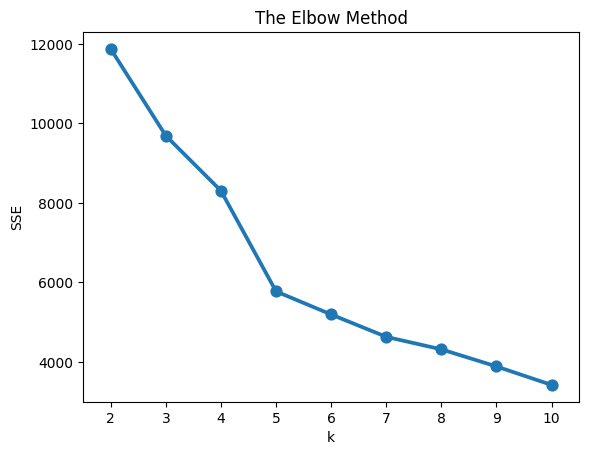

k 2: 0.229
k 3: 0.249
k 4: 0.265
k 5: 0.353
k 6: 0.375
k 7: 0.392
k 8: 0.426
k 9: 0.439
k 10: 0.481


In [85]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [86]:
# Define k
k_final = 4

Running K-Means

In [87]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   purch_d_n_night             10819 non-null  float64
 1   purch_wd_weekend            10819 non-null  float64
 2   pay_type_boleto             10819 non-null  float64
 3   pay_type_credit_card        10819 non-null  float64
 4   pay_type_debit_card         10819 non-null  float64
 5   pay_type_voucher            10819 non-null  float64
 6   sp_rj_mg_or_other_sp_rj_mg  10819 non-null  float64
 7   tt_product_qty_boxcox       10819 non-null  float64
 8   avg_installments_boxcox     10819 non-null  float64
 9   recency_boxcox              10819 non-null  float64
 10  frequency_boxcox            10819 non-null  float64
 11  monetary_value_boxcox       10819 non-null  float64
 12  cluster                     10819 non-null  int32  
dtypes: float64(12), int32(1)
memory

purch_d_n_night  purch_wd_weekend  pay_type_boleto  pay_type_credit_card  \
0              1.0               0.0              0.0                   1.0   
1              1.0               1.0              0.0                   1.0   
2              1.0               1.0              0.0                   1.0   
3              0.0               0.0              0.0                   1.0   
4              0.0               0.0              0.0                   1.0   

   pay_type_debit_card  pay_type_voucher  sp_rj_mg_or_other_sp_rj_mg  \
0                  0.0               0.0                         0.0   
1                  0.0               0.0                         1.0   
2                  0.0               0.0                         0.0   
3                  0.0               0.0                         0.0   
4                  0.0               0.0                         1.0   

   tt_product_qty_boxcox  avg_installments_boxcox  recency_boxcox  \
0                    0.0                 0.969936        0.600653   
1                    0.0                 0.919067        0.619624   
2                    0.0                 0.841328        0.737707   
3                    0.0                 0.979559        0.420989   
4                    0.0                 0.893268        0.446165   

   frequency_boxcox  monetary_value_boxcox  cluster  
0               0.0               0.455168        1  
1               0.0               0.546900        3  
2               0.0               0.435395        1  
3               0.0               0.635990        1  
4               0.0               0.403111        2

Summary Statistics

In [88]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)


cluster                            0         1         2         3
purch_d_n_night             0.347059  0.357669  0.000000  1.000000
purch_wd_weekend            0.204412  0.234913  0.220532  0.267832
pay_type_boleto             0.188235  0.245805  0.215970  0.184695
pay_type_credit_card        0.711029  0.737415  0.760203  0.789325
pay_type_debit_card         0.008824  0.005888  0.011153  0.013699
pay_type_voucher            0.091176  0.010892  0.012674  0.012282
sp_rj_mg_or_other_sp_rj_mg  0.649265  0.000000  1.000000  1.000000
tt_product_qty_boxcox       0.998604  0.000000  0.000000  0.000000
avg_installments_boxcox     0.896888  0.893918  0.889016  0.889677
recency_boxcox              0.486045  0.480756  0.486436  0.487660
frequency_boxcox            0.130882  0.002944  0.008619  0.001417
monetary_value_boxcox       0.532631  0.477407  0.470520  0.465396


Snake Plot

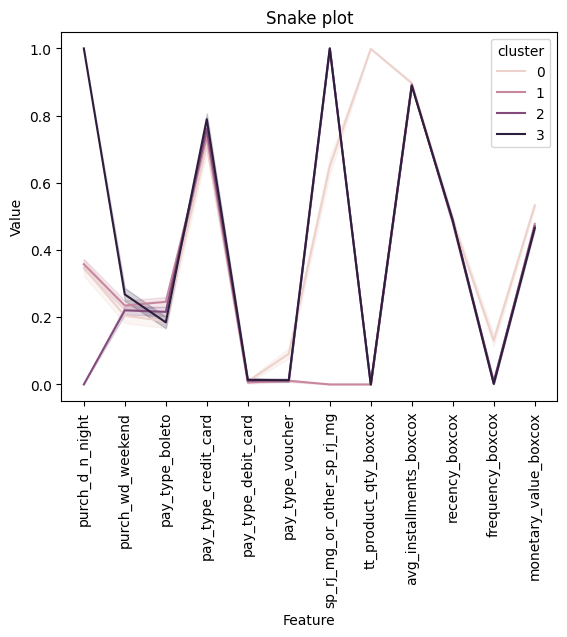

In [89]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 2 (similar to 7)

Select relevant features

In [90]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_bc_df_transf[["avg_installments_boxcox",
                                          "recency_boxcox",
                                          "monetary_value_boxcox"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avg_installments_boxcox  10819 non-null  float64
 1   recency_boxcox           10819 non-null  float64
 2   monetary_value_boxcox    10819 non-null  float64
dtypes: float64(3)
memory usage: 253.7 KB


Define Number of Clusters



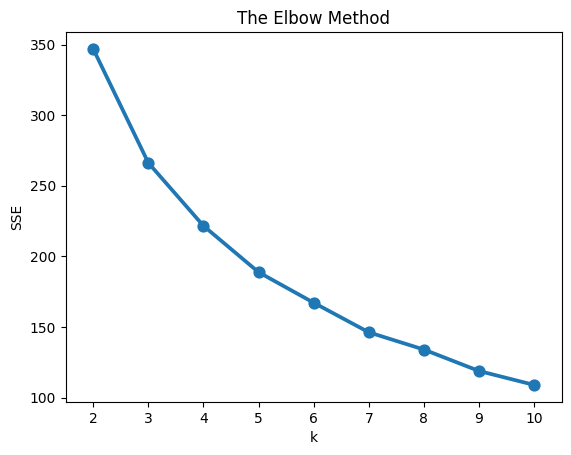

k 2: 0.390
k 3: 0.334
k 4: 0.290
k 5: 0.282
k 6: 0.273
k 7: 0.274
k 8: 0.266
k 9: 0.276
k 10: 0.275


In [91]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [92]:
# Define k
k_final = 3

Running K-Means

In [93]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   avg_installments_boxcox  10819 non-null  float64
 1   recency_boxcox           10819 non-null  float64
 2   monetary_value_boxcox    10819 non-null  float64
 3   cluster                  10819 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 296.0 KB


avg_installments_boxcox  recency_boxcox  monetary_value_boxcox  cluster
0                 0.969936        0.600653               0.455168        2
1                 0.919067        0.619624               0.546900        0
2                 0.841328        0.737707               0.435395        2
3                 0.979559        0.420989               0.635990        0
4                 0.893268        0.446165               0.403111        2

Summary Statistics

In [94]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)


cluster                         0         1         2
avg_installments_boxcox  0.906520  0.896748  0.868524
recency_boxcox           0.619418  0.287171  0.601016
monetary_value_boxcox    0.583800  0.486146  0.355620


Snake Plot

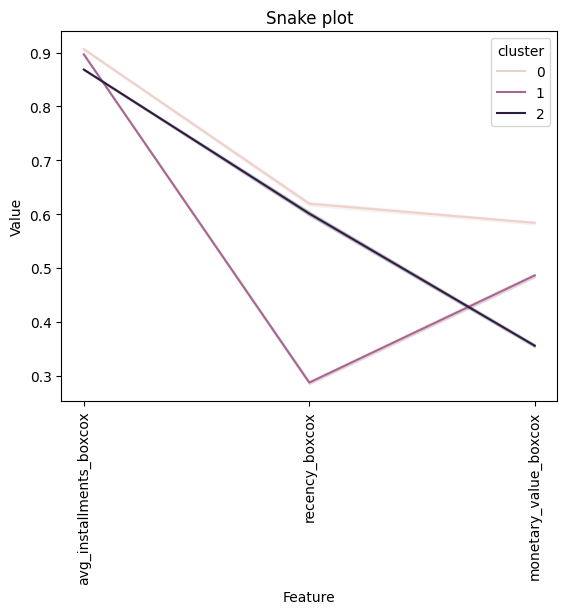

In [95]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


#### Iteration 3

Select relevant features

In [96]:
# Features
# All features in this case
kmeans_df_transf_iter = kmeans_bc_df_transf[["recency_boxcox",
                                          "monetary_value_boxcox",
                                          "pay_type_credit_card"]]

# Inspect
kmeans_df_transf_iter.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   recency_boxcox         10819 non-null  float64
 1   monetary_value_boxcox  10819 non-null  float64
 2   pay_type_credit_card   10819 non-null  float64
dtypes: float64(3)
memory usage: 253.7 KB


Define Number of Clusters



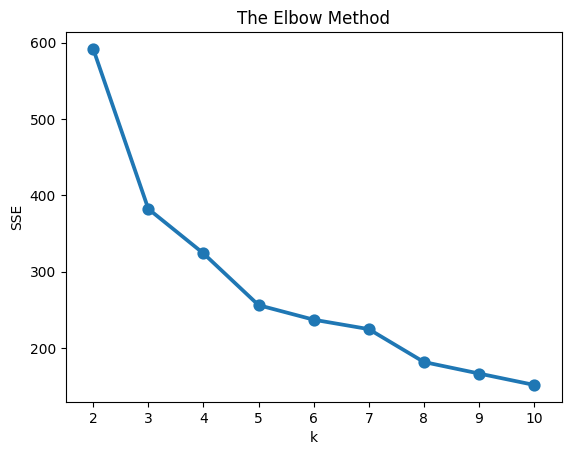

k 2: 0.724
k 3: 0.492
k 4: 0.451
k 5: 0.378
k 6: 0.362
k 7: 0.356
k 8: 0.331
k 9: 0.323
k 10: 0.331


In [97]:
# Elbow Criterion Method
# Fit KMeans and calculate SSE for each k
sse = {}

for k in range(2, 11):
    kmeans = KMeans(n_clusters = k, random_state = seed)
    kmeans.fit(kmeans_df_transf_iter)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# The elbow criterion chart
# Plot SSE for each *k*
sns.pointplot(x = sse.keys(), y = sse.values())
plt.title('The Elbow Method')
plt.xlabel('k'); plt.ylabel('SSE')
plt.show()


# Silhouette-Score Method
silh_score = {}

for k in range(2, 11):
    model = KMeans(n_clusters = k, random_state = seed)
    model.fit(kmeans_df_transf_iter)
    pred = model.predict(kmeans_df_transf_iter)
    score = silhouette_score(kmeans_df_transf_iter, pred)
    silh_score[k] = score

for k, score in silh_score.items():
  print(f"k {k}: {silh_score[k]:.3f}")


Manually define the number of clusters from previous Elbow and Sillouette-Score analysis

In [98]:
# Define k
k_final = 3

Running K-Means

In [99]:
# Run K-Means
kmeans = KMeans(n_clusters = k_final, random_state = seed)

# Fit
kmeans.fit(kmeans_df_transf_iter)

# Get Labels
cluster_labels = kmeans.labels_

# Pass labels to DataFrame
cluster_labels_df = pd.DataFrame(cluster_labels, columns = ["cluster"])

# Re-index the results to match the original order
cluster_labels_df = cluster_labels_df.set_index(original_index)
kmeans_df_transf_iter = kmeans_df_transf_iter.set_index(original_index)
kmeans_df = kmeans_df.set_index(original_index)

# Final DF
kmeans_df_transf_iter_final = pd.concat([kmeans_df_transf_iter, cluster_labels_df], axis = 1)
kmeans_df_final = pd.concat([kmeans_df, cluster_labels_df], axis = 1)

kmeans_df_transf_iter_final.info()
kmeans_df_transf_iter_final.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   recency_boxcox         10819 non-null  float64
 1   monetary_value_boxcox  10819 non-null  float64
 2   pay_type_credit_card   10819 non-null  float64
 3   cluster                10819 non-null  int32  
dtypes: float64(3), int32(1)
memory usage: 296.0 KB


recency_boxcox  monetary_value_boxcox  pay_type_credit_card  cluster
0        0.600653               0.455168                   1.0        0
1        0.619624               0.546900                   1.0        0
2        0.737707               0.435395                   1.0        0
3        0.420989               0.635990                   1.0        2
4        0.446165               0.403111                   1.0        2

Summary Statistics

In [100]:
# Profile and Interpret Segmentation
print(kmeans_df_transf_iter_final.groupby("cluster").agg("mean").T)


cluster                       0         1         2
recency_boxcox         0.624873  0.489574  0.301420
monetary_value_boxcox  0.487311  0.455971  0.487102
pay_type_credit_card   1.000000  0.000000  1.000000


Snake Plot

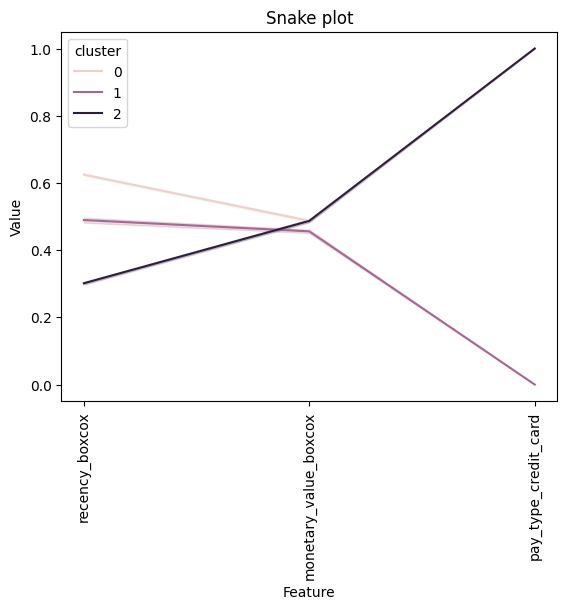

In [101]:
# Melt the data into a long format as it is needed for snake plot
kmeans_df_transf_iter_final_melt = pd.melt(
    kmeans_df_transf_iter_final,
    id_vars = "cluster",
    var_name = "Feature",
    value_name = "Value")

# Inspect
kmeans_df_transf_iter_final_melt.head()


# Visualize a snake plot
sns.lineplot(data = kmeans_df_transf_iter_final_melt,
             x = "Feature",
             y = "Value",
             hue = 'cluster')
plt.title('Snake plot')
plt.xticks(rotation = 90)
plt.show()


## Random Forest

### Import File

In [102]:
 # Substitute the file path below with your own file path from 'FINAL-GRUPOIII' folder.
 # The file name is "features_table.csv".
rf_df = pd.read_csv("/content/drive/MyDrive/Projeto1/Samba_Lovers/Project_I/APRESENTAÇÃO/FINAL-GRUPOIII/features_table.csv")

seed = 123

In [103]:
# Change cluster type
rf_df["cluster"] = rf_df["cluster"].astype("O")

# Inspect
rf_df.info()
rf_df.isna().sum()

rf_df = rf_df[rf_df["pay_type"] != "0"]

rf_df["pay_type"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10819 non-null  object 
 1   retention           10819 non-null  int64  
 2   tt_product_qty      10819 non-null  int64  
 3   tt_freight          10819 non-null  float64
 4   avg_waiting_days    10819 non-null  float64
 5   avg_del_comp_days   10819 non-null  float64
 6   avg_review_score    10739 non-null  float64
 7   purch_d_n           10819 non-null  object 
 8   purch_wd            10819 non-null  object 
 9   pay_type            10819 non-null  object 
 10  sp_rj_mg_or_other   10819 non-null  object 
 11  cluster             10819 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1014.4+ KB


pay_type
credit_card    8142
boleto         2334
voucher         237
debit_card      105
Name: count, dtype: int64

### Iteration 1: All Features (overfitting)

#### Train / Test Split

Define Features and Target

In [104]:
# Features
X = rf_df.drop(["retention", "customer_unique_id"], axis = 1)

# Target
y = rf_df["retention"]

Train / Test Split

In [105]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [106]:
# One-hot encode categorical features for training and test sets separately
# drop = "first" to eliminate one of the "dummies" and reduce multicollinearity
# handle_unknown = "ignore" ?
ohe = OneHotEncoder(drop = "first")

Imputation

In [107]:
# By default the strategy is mean
imp_num = SimpleImputer()

Define Columns

In [108]:
# Select categorical features
X_cat = X.select_dtypes("O")

# Select numerical features
X_num = X.select_dtypes(include = "number")

Preprocessor

In [109]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns),
        ("num", imp_num, X_num.columns)],
    remainder='passthrough')

#### Random Forest Model

In [110]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [111]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

##### Evaluating

In [112]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2097    2]
 [  65    0]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2099
           1       0.00      0.00      0.00        65

    accuracy                           0.97      2164
   macro avg       0.48      0.50      0.49      2164
weighted avg       0.94      0.97      0.95      2164



ROC AUC Area:  0.5


#### CV / RandomnizedSearch

In [113]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [100, 200, 300, 400, 500],
    "rf_model__max_depth": [2, 5, 10, 15],
    "rf_model__min_samples_leaf": [0.02, 0.04, 0.06, 0.08],
    "rf_model__max_features": [0.2, 0.4,0.6, 0.8],
    "rf_model__class_weight": ["balanced", "balanced_subsample"]}

# Shuffle and split the data
kf = KFold(n_splits = 5, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 10,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['purch_d_n', 'purch_wd', 'pay_type', 'sp_rj_mg_or_other', 'cluster'], dtype='object')),
                                                                              ('num',
                                                                               SimpleImputer(),
                                                                               Index(['tt_product_qty', 'tt_freight...
      dtype='object'))])),
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample'],
                                        'rf_model__max_depth': [2, 5, 10, 15],
                                        'rf_model__max_features': [0.2, 0.4,
                                                                   0.6, 0.8],
                                        'rf_model__min_samples_leaf': [0.02,
                                                                       0.04,
                                                                       0.06,
                                                                       0.08],
                                        'rf_model__n_estimators': [100, 200,
                                                                   300, 400,
                                                                   500]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [114]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 300, 'rf_model__min_samples_leaf': 0.06, 'rf_model__max_features': 0.4, 'rf_model__max_depth': 10, 'rf_model__class_weight': 'balanced'}


Best CV score (recall): 0.442


#### Evaluating (Test Set)

Accuracy

In [115]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.667


Generalization Error

In [116]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.442
Train Recall: 0.521
Test Recall: 0.431


Confusion Matrix

In [117]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred_test))



[[1415  684]
 [  37   28]]


              precision    recall  f1-score   support

           0       0.97      0.67      0.80      2099
           1       0.04      0.43      0.07        65

    accuracy                           0.67      2164
   macro avg       0.51      0.55      0.43      2164
weighted avg       0.95      0.67      0.78      2164



ROC Curve / AUC

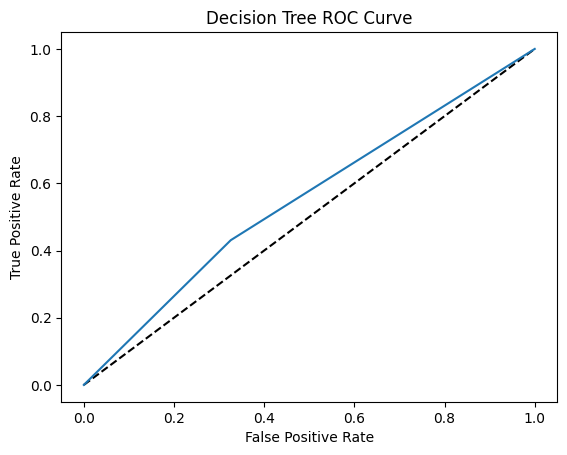



ROC AUC Area:  0.552


In [118]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

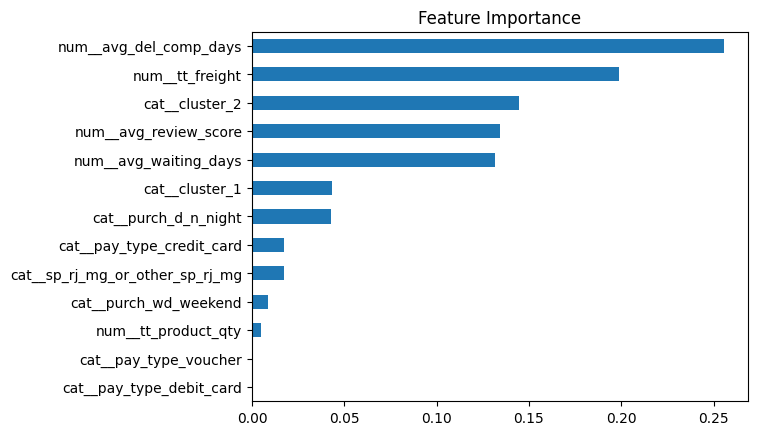

In [119]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = feature_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh")
plt.title("Feature Importance")
plt.show()

## Iteration 1.1 (Adjusting hyperparameters)

#### Train / Test Split

Define Features and Target

In [120]:
# Features
X = rf_df.drop(["retention", "customer_unique_id"], axis = 1)

# Target
y = rf_df["retention"]

Train / Test Split

In [121]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [122]:
# One-hot encode categorical features for training and test sets separately
# drop = "first" to eliminate one of the "dummies" and reduce multicollinearity
# handle_unknown = "ignore" ?
ohe = OneHotEncoder(drop = "first")

Imputation

In [123]:
# By default the strategy is mean
imp_num = SimpleImputer()

Define Columns

In [124]:
# Select categorical features
X_cat = X.select_dtypes("O")

# Select numerical features
X_num = X.select_dtypes(include = "number")

Preprocessor

In [125]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns),
        ("num", imp_num, X_num.columns)],
    remainder='passthrough')

#### Random Forest Model

In [126]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [127]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

##### Evaluating

In [128]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2097    2]
 [  65    0]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2099
           1       0.00      0.00      0.00        65

    accuracy                           0.97      2164
   macro avg       0.48      0.50      0.49      2164
weighted avg       0.94      0.97      0.95      2164



ROC AUC Area:  0.5


#### CV / RandomnizedSearch

In [129]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [40, 50, 100, 120],
    "rf_model__max_depth": [2, 3, 4, 5],
    "rf_model__min_samples_leaf": [0.1, 0.2, 0.22, 0.25],
    "rf_model__max_features": [5, 6, 7, 8, 9, 10],
    "rf_model__class_weight": ["balanced", "balanced_subsample", None]}

# Shuffle and split the data
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 30,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['purch_d_n', 'purch_wd', 'pay_type', 'sp_rj_mg_or_other', 'cluster'], dtype='object')),
                                                                              ('num',
                                                                               SimpleImputer(),
                                                                               Index(['tt_product_qty', 'tt_freigh...
      dtype='object'))])),
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=30,
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample',
                                                                   None],
                                        'rf_model__max_depth': [2, 3, 4, 5],
                                        'rf_model__max_features': [5, 6, 7, 8,
                                                                   9, 10],
                                        'rf_model__min_samples_leaf': [0.1, 0.2,
                                                                       0.22,
                                                                       0.25],
                                        'rf_model__n_estimators': [40, 50, 100,
                                                                   120]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [130]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 40, 'rf_model__min_samples_leaf': 0.25, 'rf_model__max_features': 10, 'rf_model__max_depth': 5, 'rf_model__class_weight': 'balanced_subsample'}


Best CV score (recall): 0.621


#### Evaluating (Test Set)

Accuracy

In [131]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.420


Generalization Error

In [132]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.621
Train Recall: 0.668
Test Recall: 0.677


Confusion Matrix

In [133]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred_test))



[[ 864 1235]
 [  21   44]]


              precision    recall  f1-score   support

           0       0.98      0.41      0.58      2099
           1       0.03      0.68      0.07        65

    accuracy                           0.42      2164
   macro avg       0.51      0.54      0.32      2164
weighted avg       0.95      0.42      0.56      2164



ROC Curve / AUC

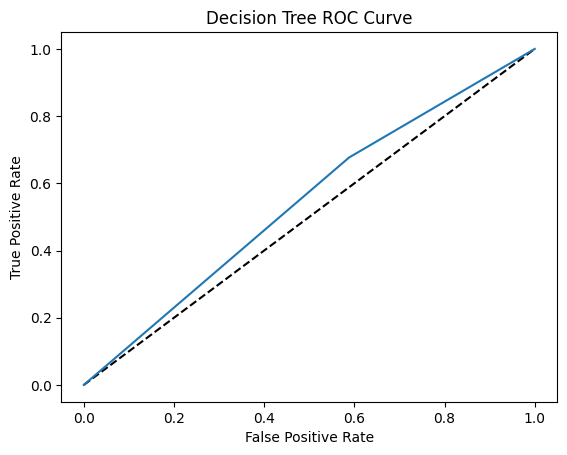



ROC AUC Area:  0.544


In [134]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

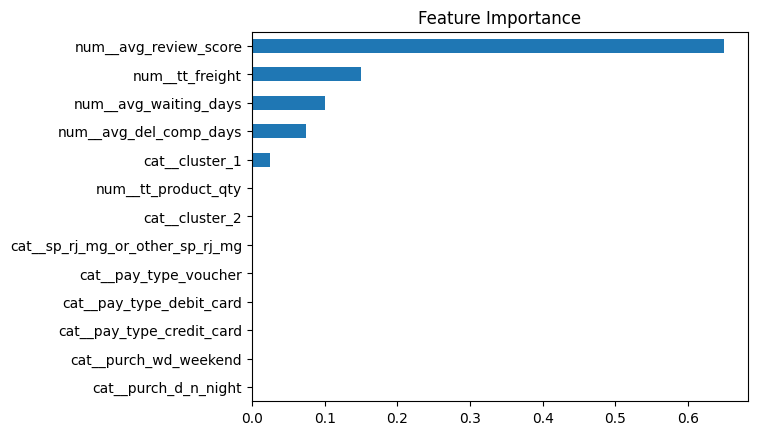

In [135]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = feature_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh")
plt.title("Feature Importance")
plt.show()

## Iteration 2 (low results)

#### Train / Test Split

Define Features and Target

In [136]:
rf_df.info()

# Features
X = rf_df[["avg_del_comp_days",
           "cluster",
           "avg_review_score",
           "tt_freight",
           "avg_waiting_days",
           "purch_d_n",
           "purch_wd",
           "sp_rj_mg_or_other"]]

# Target
y = rf_df["retention"]

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10818 non-null  object 
 1   retention           10818 non-null  int64  
 2   tt_product_qty      10818 non-null  int64  
 3   tt_freight          10818 non-null  float64
 4   avg_waiting_days    10818 non-null  float64
 5   avg_del_comp_days   10818 non-null  float64
 6   avg_review_score    10738 non-null  float64
 7   purch_d_n           10818 non-null  object 
 8   purch_wd            10818 non-null  object 
 9   pay_type            10818 non-null  object 
 10  sp_rj_mg_or_other   10818 non-null  object 
 11  cluster             10818 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


Train / Test Split

In [137]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [138]:
# One-hot encode categorical features for training and test sets separately
# drop = "first" to eliminate one of the "dummies" and reduce multicollinearity
# handle_unknown = "ignore" ?
ohe = OneHotEncoder(drop = "first")

Imputation

In [139]:
# By default the strategy is mean
imp_num = SimpleImputer()

Define Columns

In [140]:
# Select categorical features
X_cat = X.select_dtypes("O")

# Select numerical features
X_num = X.select_dtypes(include = "number")

Preprocessor

In [141]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns),
        ("num", imp_num, X_num.columns)],
    remainder='passthrough')

#### Random Forest Model

In [142]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [143]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

##### Evaluating

In [144]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2097    2]
 [  65    0]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2099
           1       0.00      0.00      0.00        65

    accuracy                           0.97      2164
   macro avg       0.48      0.50      0.49      2164
weighted avg       0.94      0.97      0.95      2164



ROC AUC Area:  0.5


#### CV / RandomnizedSearch

In [145]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [100, 200, 300, 400, 500],
    "rf_model__max_depth": [2, 5, 10, 15],
    "rf_model__min_samples_leaf": [0.02, 0.04, 0.06, 0.08],
    "rf_model__max_features": [0.2, 0.4,0.6, 0.8],
    "rf_model__class_weight": ["balanced", "balanced_subsample"]}

# Shuffle and split the data
kf = KFold(n_splits = 5, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 10,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['cluster', 'purch_d_n', 'purch_wd', 'sp_rj_mg_or_other'], dtype='object')),
                                                                              ('num',
                                                                               SimpleImputer(),
                                                                               Index(['avg_del_comp_days', 'avg_review_score',...
      dtype='object'))])),
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample'],
                                        'rf_model__max_depth': [2, 5, 10, 15],
                                        'rf_model__max_features': [0.2, 0.4,
                                                                   0.6, 0.8],
                                        'rf_model__min_samples_leaf': [0.02,
                                                                       0.04,
                                                                       0.06,
                                                                       0.08],
                                        'rf_model__n_estimators': [100, 200,
                                                                   300, 400,
                                                                   500]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [146]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 400, 'rf_model__min_samples_leaf': 0.08, 'rf_model__max_features': 0.2, 'rf_model__max_depth': 2, 'rf_model__class_weight': 'balanced_subsample'}


Best CV score (recall): 0.461


#### Evaluating (Test Set)

Accuracy

In [147]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.594


Generalization Error

In [148]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.461
Train Recall: 0.548
Test Recall: 0.477


Confusion Matrix

In [149]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred_test))



[[1255  844]
 [  34   31]]


              precision    recall  f1-score   support

           0       0.97      0.60      0.74      2099
           1       0.04      0.48      0.07        65

    accuracy                           0.59      2164
   macro avg       0.50      0.54      0.40      2164
weighted avg       0.95      0.59      0.72      2164



ROC Curve / AUC

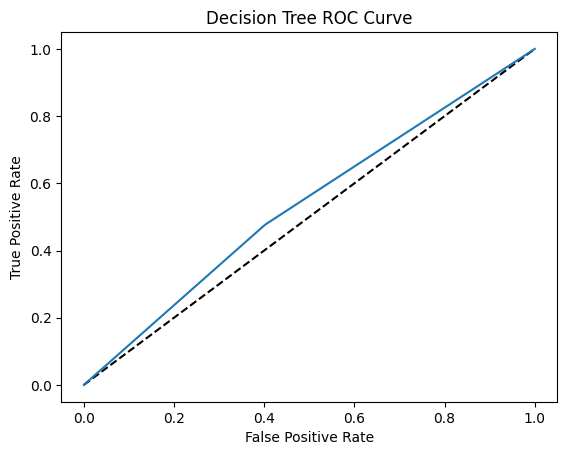



ROC AUC Area:  0.537


In [150]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

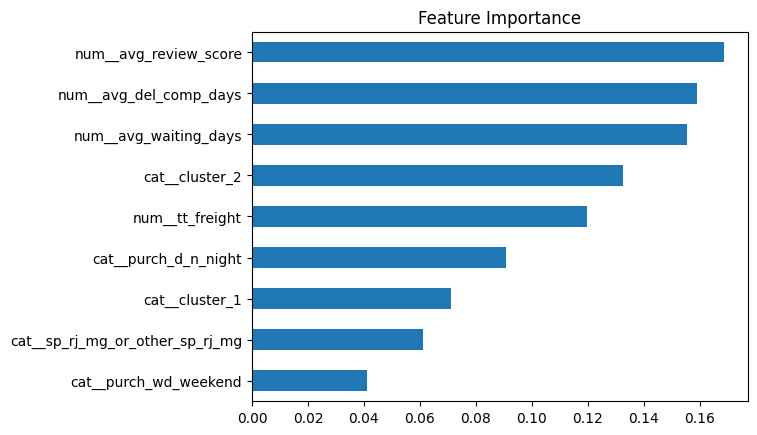

In [151]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = feature_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh")
plt.title("Feature Importance")
plt.show()

## Iteration 2.1 (change hyperparameters)

#### Train / Test Split

Define Features and Target

In [152]:
rf_df.info()

# Features
X = rf_df[["avg_del_comp_days",
           "cluster",
           "avg_review_score",
           "tt_freight",
           "avg_waiting_days",
           "purch_d_n",
           "purch_wd",
           "sp_rj_mg_or_other"]]

# Target
y = rf_df["retention"]

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10818 non-null  object 
 1   retention           10818 non-null  int64  
 2   tt_product_qty      10818 non-null  int64  
 3   tt_freight          10818 non-null  float64
 4   avg_waiting_days    10818 non-null  float64
 5   avg_del_comp_days   10818 non-null  float64
 6   avg_review_score    10738 non-null  float64
 7   purch_d_n           10818 non-null  object 
 8   purch_wd            10818 non-null  object 
 9   pay_type            10818 non-null  object 
 10  sp_rj_mg_or_other   10818 non-null  object 
 11  cluster             10818 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


Train / Test Split

In [153]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [154]:
# One-hot encode categorical features for training and test sets separately
# drop = "first" to eliminate one of the "dummies" and reduce multicollinearity
# handle_unknown = "ignore" ?
ohe = OneHotEncoder(drop = "first")

Imputation

In [155]:
# By default the strategy is mean
imp_num = SimpleImputer()

Define Columns

In [156]:
# Select categorical features
X_cat = X.select_dtypes("O")

# Select numerical features
X_num = X.select_dtypes(include = "number")

Preprocessor

In [157]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns),
        ("num", imp_num, X_num.columns)],
    remainder='passthrough')

#### Random Forest Model

In [158]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [159]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

##### Evaluating

In [160]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2097    2]
 [  65    0]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2099
           1       0.00      0.00      0.00        65

    accuracy                           0.97      2164
   macro avg       0.48      0.50      0.49      2164
weighted avg       0.94      0.97      0.95      2164



ROC AUC Area:  0.5


#### CV / RandomnizedSearch

In [161]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [50, 100, 150, 200],
    "rf_model__max_depth": [3, 4, 5, 6, 8],
    "rf_model__min_samples_leaf": [0.2, 0.22, 0.25, 0.27, 0.3],
    "rf_model__max_features": [1, 2, 3, 4, 5, 6, 7, 8],    # not relevant as they are only few
    "rf_model__class_weight": ["balanced", "balanced_subsample", None]}

# Shuffle and split the data
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 30,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['cluster', 'purch_d_n', 'purch_wd', 'sp_rj_mg_or_other'], dtype='object')),
                                                                              ('num',
                                                                               SimpleImputer(),
                                                                               Index(['avg_del_comp_days', 'avg_review_score'...
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=30,
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample',
                                                                   None],
                                        'rf_model__max_depth': [3, 4, 5, 6, 8],
                                        'rf_model__max_features': [1, 2, 3, 4,
                                                                   5, 6, 7, 8],
                                        'rf_model__min_samples_leaf': [0.2,
                                                                       0.22,
                                                                       0.25,
                                                                       0.27,
                                                                       0.3],
                                        'rf_model__n_estimators': [50, 100, 150,
                                                                   200]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [162]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 50, 'rf_model__min_samples_leaf': 0.25, 'rf_model__max_features': 6, 'rf_model__max_depth': 3, 'rf_model__class_weight': 'balanced'}


Best CV score (recall): 0.625


#### Evaluating (Test Set)

Accuracy

In [163]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.420


Generalization Error

In [164]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.625
Train Recall: 0.668
Test Recall: 0.677


Confusion Matrix

In [165]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred_test))



[[ 864 1235]
 [  21   44]]


              precision    recall  f1-score   support

           0       0.98      0.41      0.58      2099
           1       0.03      0.68      0.07        65

    accuracy                           0.42      2164
   macro avg       0.51      0.54      0.32      2164
weighted avg       0.95      0.42      0.56      2164



ROC Curve / AUC

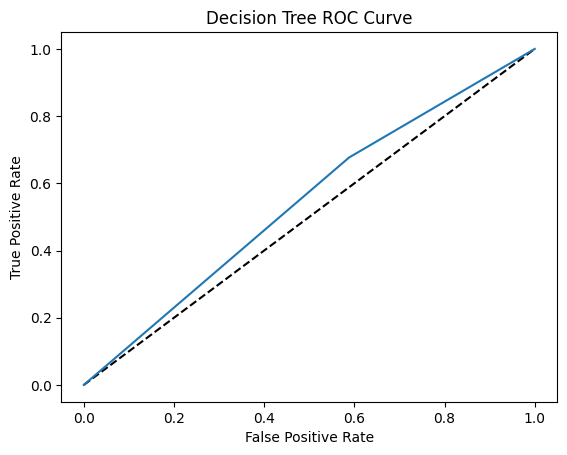



ROC AUC Area:  0.544


In [166]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

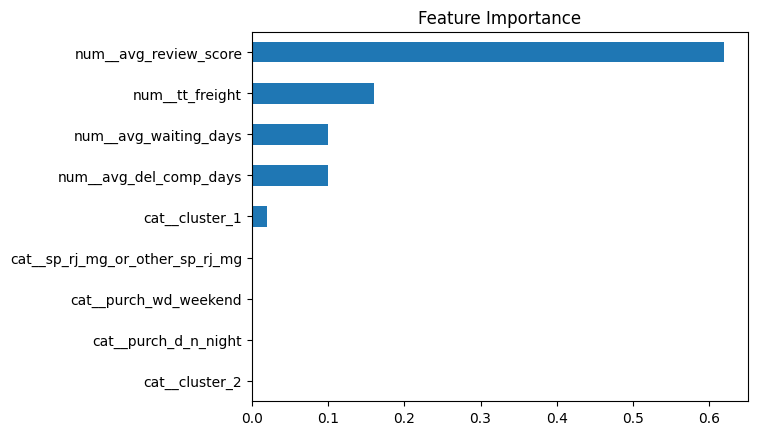

In [167]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = feature_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh")
plt.title("Feature Importance")
plt.show()

## Iteration 3

#### Train / Test Split

Define Features and Target

In [168]:
rf_df.info()

# Features
X = rf_df[["avg_del_comp_days",
           "cluster",
           "avg_review_score",
           "tt_freight",
           "avg_waiting_days"]]

# Target
y = rf_df["retention"]

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10818 non-null  object 
 1   retention           10818 non-null  int64  
 2   tt_product_qty      10818 non-null  int64  
 3   tt_freight          10818 non-null  float64
 4   avg_waiting_days    10818 non-null  float64
 5   avg_del_comp_days   10818 non-null  float64
 6   avg_review_score    10738 non-null  float64
 7   purch_d_n           10818 non-null  object 
 8   purch_wd            10818 non-null  object 
 9   pay_type            10818 non-null  object 
 10  sp_rj_mg_or_other   10818 non-null  object 
 11  cluster             10818 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


Train / Test Split

In [169]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [170]:
# One-hot encode categorical features for training and test sets separately
# drop = "first" to eliminate one of the "dummies" and reduce multicollinearity
# handle_unknown = "ignore" ?
ohe = OneHotEncoder(drop = "first")

Imputation

In [171]:
# By default the strategy is mean
imp_num = SimpleImputer()

Define Columns

In [172]:
# Select categorical features
X_cat = X.select_dtypes("O")

# Select numerical features
X_num = X.select_dtypes(include = "number")

Preprocessor

In [173]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns),
        ("num", imp_num, X_num.columns)],
    remainder='passthrough')

#### Random Forest Model

In [174]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [175]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

##### Evaluating

In [176]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2091    8]
 [  64    1]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2099
           1       0.11      0.02      0.03        65

    accuracy                           0.97      2164
   macro avg       0.54      0.51      0.51      2164
weighted avg       0.94      0.97      0.95      2164



ROC AUC Area:  0.506


#### CV / RandomnizedSearch

In [177]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [100, 200, 300, 400, 500],
    "rf_model__max_depth": [2, 5, 10, 15],
    "rf_model__min_samples_leaf": [0.02, 0.04, 0.06, 0.08],
    "rf_model__max_features": [0.2, 0.4,0.6, 0.8],
    "rf_model__class_weight": ["balanced", "balanced_subsample"]}

# Shuffle and split the data
kf = KFold(n_splits = 5, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 10,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['cluster'], dtype='object')),
                                                                              ('num',
                                                                               SimpleImputer(),
                                                                               Index(['avg_del_comp_days', 'avg_review_score', 'tt_freight',
       'avg_waiting_days'],
      dtype='obj...])),
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample'],
                                        'rf_model__max_depth': [2, 5, 10, 15],
                                        'rf_model__max_features': [0.2, 0.4,
                                                                   0.6, 0.8],
                                        'rf_model__min_samples_leaf': [0.02,
                                                                       0.04,
                                                                       0.06,
                                                                       0.08],
                                        'rf_model__n_estimators': [100, 200,
                                                                   300, 400,
                                                                   500]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [178]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 100, 'rf_model__min_samples_leaf': 0.06, 'rf_model__max_features': 0.8, 'rf_model__max_depth': 15, 'rf_model__class_weight': 'balanced'}


Best CV score (recall): 0.463


#### Evaluating (Test Set)

Accuracy

In [179]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.650


Generalization Error

In [180]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.463
Train Recall: 0.560
Test Recall: 0.385


Confusion Matrix

In [181]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred_test))



[[1382  717]
 [  40   25]]


              precision    recall  f1-score   support

           0       0.97      0.66      0.79      2099
           1       0.03      0.38      0.06        65

    accuracy                           0.65      2164
   macro avg       0.50      0.52      0.42      2164
weighted avg       0.94      0.65      0.76      2164



ROC Curve / AUC

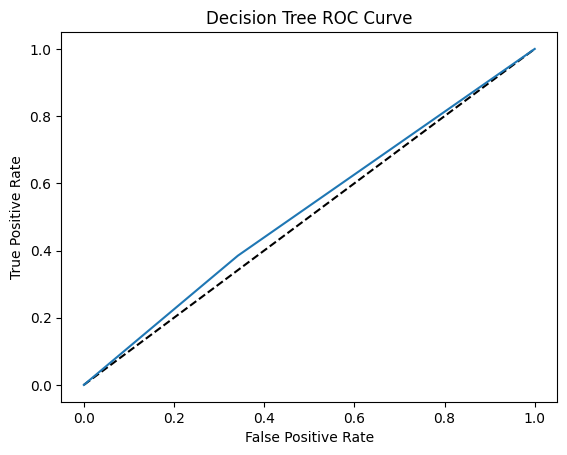



ROC AUC Area:  0.522


In [182]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

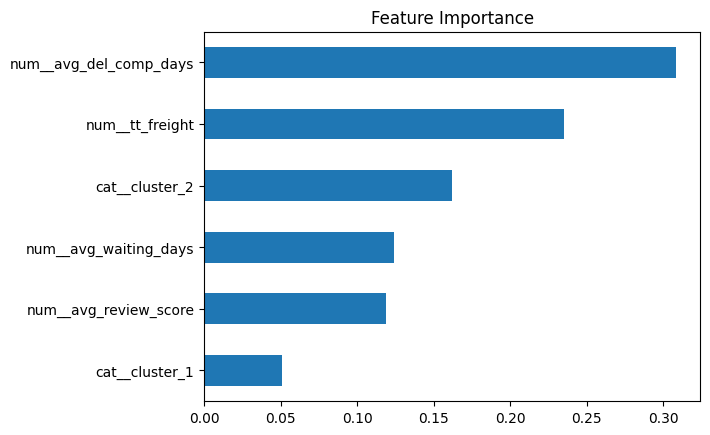

In [183]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = feature_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh")
plt.title("Feature Importance")
plt.show()

## Iteration 3.1 (change hyperparameters)

#### Train / Test Split

Define Features and Target

In [184]:
rf_df.info()

# Features
X = rf_df[["avg_del_comp_days",
           "cluster",
           "avg_review_score",
           "tt_freight",
           "avg_waiting_days"]]

# Target
y = rf_df["retention"]

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10818 non-null  object 
 1   retention           10818 non-null  int64  
 2   tt_product_qty      10818 non-null  int64  
 3   tt_freight          10818 non-null  float64
 4   avg_waiting_days    10818 non-null  float64
 5   avg_del_comp_days   10818 non-null  float64
 6   avg_review_score    10738 non-null  float64
 7   purch_d_n           10818 non-null  object 
 8   purch_wd            10818 non-null  object 
 9   pay_type            10818 non-null  object 
 10  sp_rj_mg_or_other   10818 non-null  object 
 11  cluster             10818 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


Train / Test Split

In [185]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [186]:
# One-hot encode categorical features for training and test sets separately
# drop = "first" to eliminate one of the "dummies" and reduce multicollinearity
# handle_unknown = "ignore" ?
ohe = OneHotEncoder(drop = "first")

Imputation

In [187]:
# By default the strategy is mean
imp_num = SimpleImputer()

Define Columns

In [188]:
# Select categorical features
X_cat = X.select_dtypes("O")

# Select numerical features
X_num = X.select_dtypes(include = "number")

Preprocessor

In [189]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns),
        ("num", imp_num, X_num.columns)],
    remainder='passthrough')

#### Random Forest Model

In [190]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [191]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

##### Evaluating

In [192]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2091    8]
 [  64    1]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2099
           1       0.11      0.02      0.03        65

    accuracy                           0.97      2164
   macro avg       0.54      0.51      0.51      2164
weighted avg       0.94      0.97      0.95      2164



ROC AUC Area:  0.506


#### CV / RandomnizedSearch

In [193]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [40, 50, 100, 120],
    "rf_model__max_depth": [2, 3, 4, 5],
    "rf_model__min_samples_leaf": [0.1, 0.2, 0.22, 0.25],
    "rf_model__max_features": [0.1, 0.15, 0.17, 0.19, 0.2],
    "rf_model__class_weight": ["balanced", "balanced_subsample", None]}

# Shuffle and split the data
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 30,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['cluster'], dtype='object')),
                                                                              ('num',
                                                                               SimpleImputer(),
                                                                               Index(['avg_del_comp_days', 'avg_review_score', 'tt_freight',
       'avg_waiting_days'],
      dtype='ob...
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=30,
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample',
                                                                   None],
                                        'rf_model__max_depth': [2, 3, 4, 5],
                                        'rf_model__max_features': [0.1, 0.15,
                                                                   0.17, 0.19,
                                                                   0.2],
                                        'rf_model__min_samples_leaf': [0.1, 0.2,
                                                                       0.22,
                                                                       0.25],
                                        'rf_model__n_estimators': [40, 50, 100,
                                                                   120]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [194]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 120, 'rf_model__min_samples_leaf': 0.25, 'rf_model__max_features': 0.17, 'rf_model__max_depth': 5, 'rf_model__class_weight': 'balanced_subsample'}


Best CV score (recall): 0.522


#### Evaluating (Test Set)

Accuracy

In [195]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.486


Generalization Error

In [196]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.522
Train Recall: 0.614
Test Recall: 0.569


Confusion Matrix

In [197]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred_test))



[[1014 1085]
 [  28   37]]


              precision    recall  f1-score   support

           0       0.97      0.48      0.65      2099
           1       0.03      0.57      0.06        65

    accuracy                           0.49      2164
   macro avg       0.50      0.53      0.35      2164
weighted avg       0.94      0.49      0.63      2164



ROC Curve / AUC

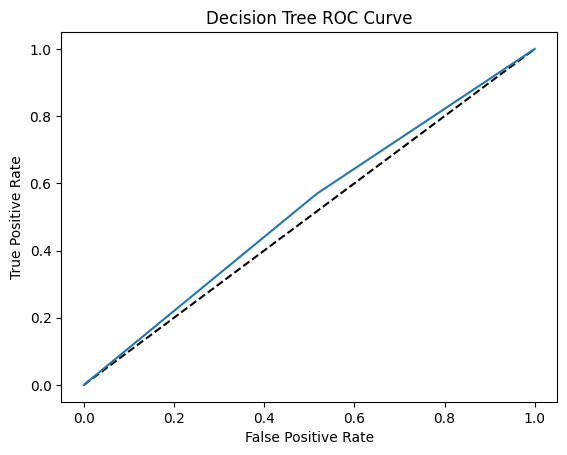



ROC AUC Area:  0.526


In [198]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

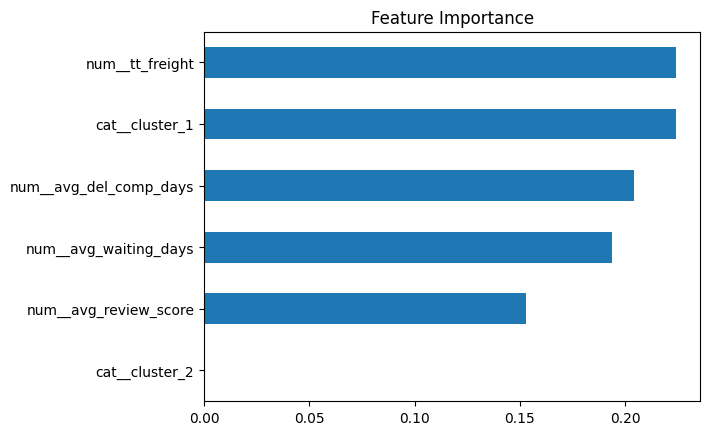

In [199]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = feature_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh")
plt.title("Feature Importance")
plt.show()

## Iteration 3.2

#### Train / Test Split

Define Features and Target

In [200]:
rf_df.info()

# Features
X = rf_df[["avg_del_comp_days",
           "cluster",
           "avg_review_score",
           "tt_freight",
           "avg_waiting_days"]]

# Target
y = rf_df["retention"]

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10818 non-null  object 
 1   retention           10818 non-null  int64  
 2   tt_product_qty      10818 non-null  int64  
 3   tt_freight          10818 non-null  float64
 4   avg_waiting_days    10818 non-null  float64
 5   avg_del_comp_days   10818 non-null  float64
 6   avg_review_score    10738 non-null  float64
 7   purch_d_n           10818 non-null  object 
 8   purch_wd            10818 non-null  object 
 9   pay_type            10818 non-null  object 
 10  sp_rj_mg_or_other   10818 non-null  object 
 11  cluster             10818 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


Train / Test Split

In [201]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [202]:
# One-hot encode categorical features for training and test sets separately
# drop = "first" to eliminate one of the "dummies" and reduce multicollinearity
# handle_unknown = "ignore" ?
ohe = OneHotEncoder(drop = "first")

Imputation

In [203]:
# By default the strategy is mean
imp_num = SimpleImputer()

Define Columns

In [204]:
# Select categorical features
X_cat = X.select_dtypes("O")

# Select numerical features
X_num = X.select_dtypes(include = "number")

Preprocessor

In [205]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns),
        ("num", imp_num, X_num.columns)],
    remainder='passthrough')

#### Random Forest Model

In [206]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [207]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

##### Evaluating

In [208]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2091    8]
 [  64    1]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2099
           1       0.11      0.02      0.03        65

    accuracy                           0.97      2164
   macro avg       0.54      0.51      0.51      2164
weighted avg       0.94      0.97      0.95      2164



ROC AUC Area:  0.506


#### CV / RandomnizedSearch

In [209]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [100, 150, 200, 250, 300],
    "rf_model__max_depth": [2, 3, 4, 5, 6, 8],
    "rf_model__min_samples_leaf": [0.2, 0.22, 0.25, 0.27, 0.3],
    "rf_model__max_features": [1, 2, 3, 4, 5],    # not relevant as they are only few
    "rf_model__class_weight": ["balanced", "balanced_subsample", None]}

# Shuffle and split the data
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 30,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['cluster'], dtype='object')),
                                                                              ('num',
                                                                               SimpleImputer(),
                                                                               Index(['avg_del_comp_days', 'avg_review_score', 'tt_freight',
       'avg_waiting_days'],
      dtype='ob...
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=30,
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample',
                                                                   None],
                                        'rf_model__max_depth': [2, 3, 4, 5, 6,
                                                                8],
                                        'rf_model__max_features': [1, 2, 3, 4,
                                                                   5],
                                        'rf_model__min_samples_leaf': [0.2,
                                                                       0.22,
                                                                       0.25,
                                                                       0.27,
                                                                       0.3],
                                        'rf_model__n_estimators': [100, 150,
                                                                   200, 250,
                                                                   300]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [210]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 300, 'rf_model__min_samples_leaf': 0.25, 'rf_model__max_features': 4, 'rf_model__max_depth': 8, 'rf_model__class_weight': 'balanced'}


Best CV score (recall): 0.621


#### Evaluating (Test Set)

Accuracy

In [211]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.419


Generalization Error

In [212]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.621
Train Recall: 0.668
Test Recall: 0.677


Confusion Matrix

In [213]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred_test))



[[ 862 1237]
 [  21   44]]


              precision    recall  f1-score   support

           0       0.98      0.41      0.58      2099
           1       0.03      0.68      0.07        65

    accuracy                           0.42      2164
   macro avg       0.51      0.54      0.32      2164
weighted avg       0.95      0.42      0.56      2164



ROC Curve / AUC

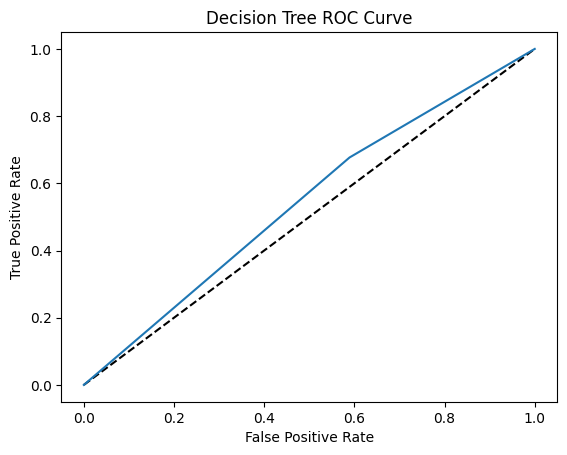



ROC AUC Area:  0.544


In [214]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

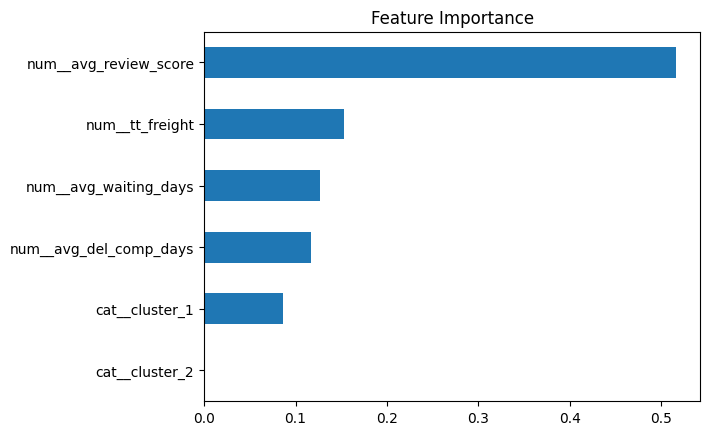

In [215]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = feature_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh")
plt.title("Feature Importance")
plt.show()

## Iteration 3.3 (imputation with median)

#### Train / Test Split

Define Features and Target

In [216]:
rf_df.info()

# Features
X = rf_df[["avg_del_comp_days",
           "cluster",
           "avg_review_score",
           "tt_freight",
           "avg_waiting_days"]]

# Target
y = rf_df["retention"]

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10818 non-null  object 
 1   retention           10818 non-null  int64  
 2   tt_product_qty      10818 non-null  int64  
 3   tt_freight          10818 non-null  float64
 4   avg_waiting_days    10818 non-null  float64
 5   avg_del_comp_days   10818 non-null  float64
 6   avg_review_score    10738 non-null  float64
 7   purch_d_n           10818 non-null  object 
 8   purch_wd            10818 non-null  object 
 9   pay_type            10818 non-null  object 
 10  sp_rj_mg_or_other   10818 non-null  object 
 11  cluster             10818 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


Train / Test Split

In [217]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [218]:
# One-hot encode categorical features for training and test sets separately
# drop = "first" to eliminate one of the "dummies" and reduce multicollinearity
# handle_unknown = "ignore" ?
ohe = OneHotEncoder(drop = "first")

Imputation

In [219]:
# By default the strategy is mean
imp_num = SimpleImputer(strategy = "median")

Define Columns

In [220]:
# Select categorical features
X_cat = X.select_dtypes("O")

# Select numerical features
X_num = X.select_dtypes(include = "number")

Preprocessor

In [221]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns),
        ("num", imp_num, X_num.columns)],
    remainder='passthrough')

#### Random Forest Model

In [222]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [223]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

##### Evaluating

In [224]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2091    8]
 [  64    1]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2099
           1       0.11      0.02      0.03        65

    accuracy                           0.97      2164
   macro avg       0.54      0.51      0.51      2164
weighted avg       0.94      0.97      0.95      2164



ROC AUC Area:  0.506


#### CV / RandomnizedSearch

In [225]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [100, 150, 200, 250, 300],
    "rf_model__max_depth": [2, 3, 4, 5, 6, 8],
    "rf_model__min_samples_leaf": [0.2, 0.22, 0.25, 0.27, 0.3],
    "rf_model__max_features": [1, 2, 3, 4, 5],    # not relevant as they are only few
    "rf_model__class_weight": ["balanced", "balanced_subsample", None]}

# Shuffle and split the data
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 30,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['cluster'], dtype='object')),
                                                                              ('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               Index(['avg_del_comp_days', 'avg_review_score', 'tt_freight',
       'avg_waiting...
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=30,
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample',
                                                                   None],
                                        'rf_model__max_depth': [2, 3, 4, 5, 6,
                                                                8],
                                        'rf_model__max_features': [1, 2, 3, 4,
                                                                   5],
                                        'rf_model__min_samples_leaf': [0.2,
                                                                       0.22,
                                                                       0.25,
                                                                       0.27,
                                                                       0.3],
                                        'rf_model__n_estimators': [100, 150,
                                                                   200, 250,
                                                                   300]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [ ]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 300, 'rf_model__min_samples_leaf': 0.25, 'rf_model__max_features': 4, 'rf_model__max_depth': 8, 'rf_model__class_weight': 'balanced'}


Best CV score (recall): 0.626


#### Evaluating (Test Set)

Accuracy

In [ ]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.409


Generalization Error

In [ ]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.626
Train Recall: 0.676
Test Recall: 0.677


Confusion Matrix

In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred_test))



[[ 842 1257]
 [  21   44]]


              precision    recall  f1-score   support

           0       0.98      0.40      0.57      2099
           1       0.03      0.68      0.06        65

    accuracy                           0.41      2164
   macro avg       0.50      0.54      0.32      2164
weighted avg       0.95      0.41      0.55      2164



ROC Curve / AUC

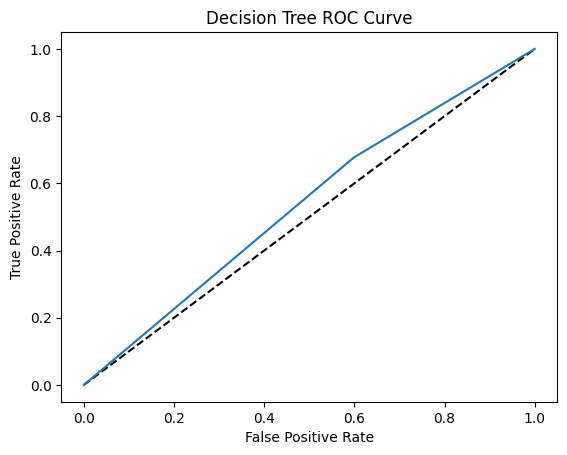



ROC AUC Area:  0.539


In [ ]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

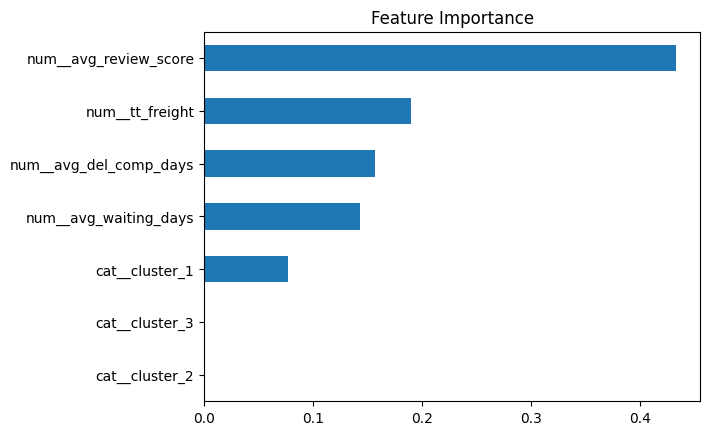

In [ ]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = feature_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh")
plt.title("Feature Importance")
plt.show()

## Iteration 3.3.1 (remove clusters)

#### Train / Test Split

Define Features and Target

In [ ]:
rf_df.info()

# Features
X = rf_df[["avg_del_comp_days",
           "cluster",
           "avg_review_score",
           "tt_freight",
           "avg_waiting_days"]]

# Target
y = rf_df["retention"]

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10818 non-null  object 
 1   retention           10818 non-null  int64  
 2   tt_product_qty      10818 non-null  int64  
 3   tt_freight          10818 non-null  float64
 4   avg_waiting_days    10818 non-null  float64
 5   avg_del_comp_days   10818 non-null  float64
 6   avg_review_score    10738 non-null  float64
 7   purch_d_n           10818 non-null  object 
 8   purch_wd            10818 non-null  object 
 9   pay_type            10818 non-null  object 
 10  sp_rj_mg_or_other   10818 non-null  object 
 11  cluster             10818 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB


Train / Test Split

In [ ]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [ ]:
# One-hot encode categorical features for training and test sets separately
# remove drop = "first"
ohe = OneHotEncoder()

Imputation

In [ ]:
# By default the strategy is mean
imp_num = SimpleImputer(strategy = "median")

Define Columns

In [ ]:
# Select categorical features
X_cat = X.select_dtypes("O")

# Select numerical features
X_num = X.select_dtypes(include = "number")

Preprocessor

In [ ]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns),
        ("num", imp_num, X_num.columns)],
    remainder='passthrough')

#### Random Forest Model

In [ ]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [ ]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
          ("column_remover", FunctionTransformer(lambda array: pd.DataFrame(array).drop(
            columns = [0, 2, 3]))),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Check names to remove the correct index and keep cluster_1
print(pipeline.named_steps['preprocessor'].get_feature_names_out())

# Predict
y_pred = pipeline.predict(X_test)

['cat__cluster_0' 'cat__cluster_1' 'cat__cluster_2' 'cat__cluster_3'
 'num__avg_del_comp_days' 'num__avg_review_score' 'num__tt_freight'
 'num__avg_waiting_days']


##### Evaluating

In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2087   12]
 [  64    1]]


              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2099
           1       0.08      0.02      0.03        65

    accuracy                           0.96      2164
   macro avg       0.52      0.50      0.50      2164
weighted avg       0.94      0.96      0.95      2164



ROC AUC Area:  0.505


#### CV / RandomnizedSearch

In [ ]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [100, 150, 200, 250, 300],
    "rf_model__max_depth": [2, 3, 4, 5, 6, 8],
    "rf_model__min_samples_leaf": [0.2, 0.22, 0.25, 0.27, 0.3],
    "rf_model__max_features": [1, 2, 3, 4, 5],    # not relevant as they are only few
    "rf_model__class_weight": ["balanced", "balanced_subsample", None]}

# Shuffle and split the data
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 30,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(),
                                                                               Index(['cluster'], dtype='object')),
                                                                              ('num',
                                                                               SimpleImputer(strategy='median'),
                                                                               Index(['avg_del_comp_days', 'avg_review_score', 'tt_freight',
       'avg_waiting_days'],
      dtyp...
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=30,
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample',
                                                                   None],
                                        'rf_model__max_depth': [2, 3, 4, 5, 6,
                                                                8],
                                        'rf_model__max_features': [1, 2, 3, 4,
                                                                   5],
                                        'rf_model__min_samples_leaf': [0.2,
                                                                       0.22,
                                                                       0.25,
                                                                       0.27,
                                                                       0.3],
                                        'rf_model__n_estimators': [100, 150,
                                                                   200, 250,
                                                                   300]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [ ]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 300, 'rf_model__min_samples_leaf': 0.25, 'rf_model__max_features': 4, 'rf_model__max_depth': 8, 'rf_model__class_weight': 'balanced'}


Best CV score (recall): 0.639


#### Evaluating (Test Set)

Accuracy

In [ ]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.409


Generalization Error

In [ ]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.639
Train Recall: 0.676
Test Recall: 0.677


Confusion Matrix

[[ 842 1257]
 [  21   44]]




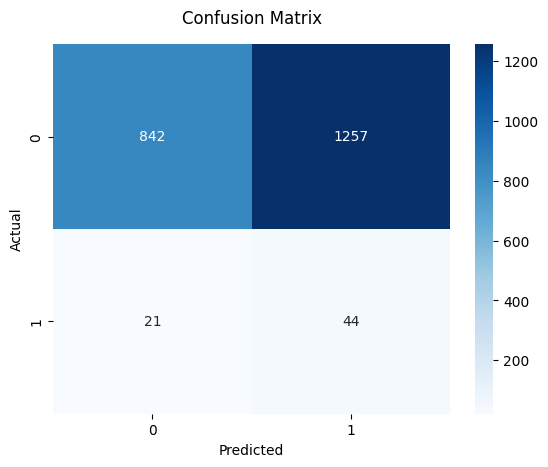

              precision    recall  f1-score   support

           0       0.98      0.40      0.57      2099
           1       0.03      0.68      0.06        65

    accuracy                           0.41      2164
   macro avg       0.50      0.54      0.32      2164
weighted avg       0.95      0.41      0.55      2164



In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

sns.heatmap(confusion_matrix(y_test, y_pred_test),
            annot=True,
            fmt='d',
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', pad = 15)
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_test))



ROC Curve / AUC

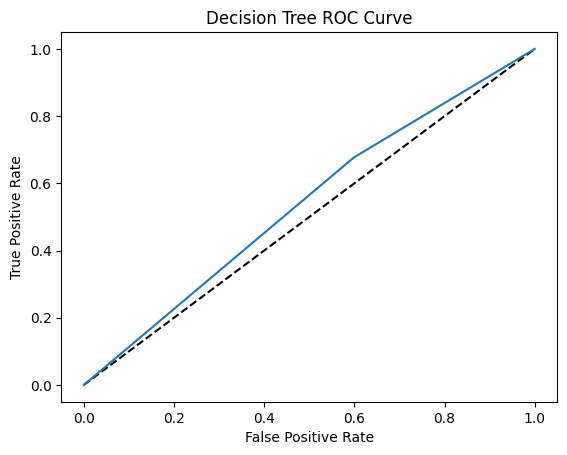



ROC AUC Area:  0.539


In [ ]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

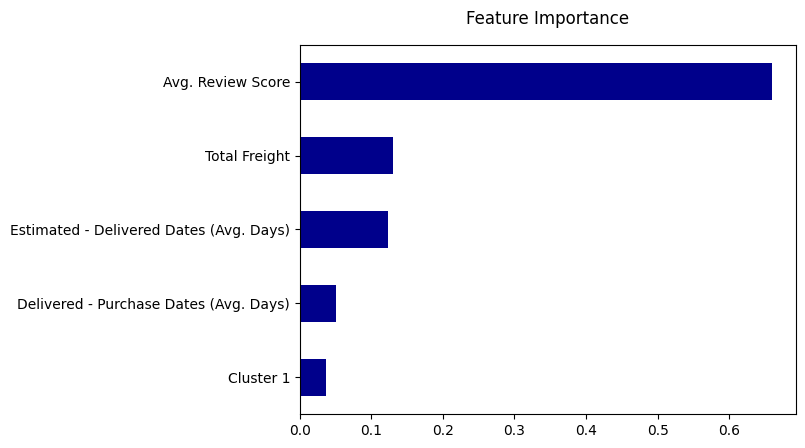

['cat__cluster_0', 'cat__cluster_1', 'cat__cluster_2', 'cat__cluster_3', 'num__avg_del_comp_days', 'num__avg_review_score', 'num__tt_freight', 'num__avg_waiting_days']


In [ ]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

new_names = [
    "Cluster 1", "Estimated - Delivered Dates (Avg. Days)",\
    "Avg. Review Score", "Total Freight", "Delivered - Purchase Dates (Avg. Days)"]

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = new_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh",
                           color = "#00008B")
plt.title("Feature Importance", pad = 15)
plt.show()

print(feature_names)
feature_names_name = feature_names[0]

## Iteration 3.4 (remove missing values)

#### Train / Test Split

Define Features and Target

In [ ]:
rf_df.info()

# Removing missing values on review_score
rf_df_dropna = rf_df.dropna(subset = ["avg_review_score"])
rf_df_dropna.info()

# Features
X = rf_df_dropna[["avg_del_comp_days",
           "cluster",
           "avg_review_score",
           "tt_freight",
           "avg_waiting_days"]]

# Target
y = rf_df_dropna["retention"]

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10818 non-null  object 
 1   retention           10818 non-null  int64  
 2   tt_product_qty      10818 non-null  int64  
 3   tt_freight          10818 non-null  float64
 4   avg_waiting_days    10818 non-null  float64
 5   avg_del_comp_days   10818 non-null  float64
 6   avg_review_score    10738 non-null  float64
 7   purch_d_n           10818 non-null  object 
 8   purch_wd            10818 non-null  object 
 9   pay_type            10818 non-null  object 
 10  sp_rj_mg_or_other   10818 non-null  object 
 11  cluster             10818 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 10738 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dty

Train / Test Split

In [ ]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [ ]:
# One-hot encode categorical features for training and test sets separately
# drop = "first" to eliminate one of the "dummies" and reduce multicollinearity
# handle_unknown = "ignore" ?
ohe = OneHotEncoder(drop = "first")

Imputation

In [ ]:
# No numerical imputation

Define Columns

In [ ]:
# Select categorical features
X_cat = X.select_dtypes("O")

Preprocessor

In [ ]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns)],
    remainder='passthrough')

#### Random Forest Model

In [ ]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [ ]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
         ("rf_model", rf)])

# Fit
pipeline.fit(X_train, y_train)

# Predict
y_pred = pipeline.predict(X_test)

##### Evaluating

In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2079    5]
 [  64    0]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2084
           1       0.00      0.00      0.00        64

    accuracy                           0.97      2148
   macro avg       0.49      0.50      0.49      2148
weighted avg       0.94      0.97      0.95      2148



ROC AUC Area:  0.499


#### CV / RandomnizedSearch

In [ ]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [100, 150, 200, 250, 300],
    "rf_model__max_depth": [2, 3, 4, 5, 6, 8],
    "rf_model__min_samples_leaf": [0.2, 0.22, 0.25, 0.27, 0.3],
    "rf_model__max_features": [1, 2, 3, 4, 5],    # not relevant as they are only few
    "rf_model__class_weight": ["balanced", "balanced_subsample", None]}

# Shuffle and split the data
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 30,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(drop='first'),
                                                                               Index(['cluster'], dtype='object'))])),
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=30,
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample',
                                                                   None],
                                        'rf_model__max_depth': [2, 3, 4, 5, 6,
                                                                8],
                                        'rf_model__max_features': [1, 2, 3, 4,
                                                                   5],
                                        'rf_model__min_samples_leaf': [0.2,
                                                                       0.22,
                                                                       0.25,
                                                                       0.27,
                                                                       0.3],
                                        'rf_model__n_estimators': [100, 150,
                                                                   200, 250,
                                                                   300]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [ ]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 300, 'rf_model__min_samples_leaf': 0.25, 'rf_model__max_features': 4, 'rf_model__max_depth': 8, 'rf_model__class_weight': 'balanced'}


Best CV score (recall): 0.621


#### Evaluating (Test Set)

Accuracy

In [ ]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.435


Generalization Error

In [ ]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.621
Train Recall: 0.682
Test Recall: 0.641


Confusion Matrix

[[ 894 1190]
 [  23   41]]




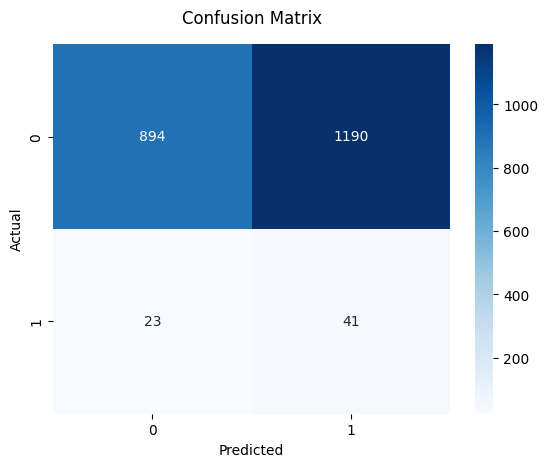

              precision    recall  f1-score   support

           0       0.97      0.43      0.60      2084
           1       0.03      0.64      0.06        64

    accuracy                           0.44      2148
   macro avg       0.50      0.53      0.33      2148
weighted avg       0.95      0.44      0.58      2148



In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

sns.heatmap(confusion_matrix(y_test, y_pred_test),
            annot=True,
            fmt='d',
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', pad = 15)
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_test))



ROC Curve / AUC

<ipython-input-61-4e82e4c75293>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color = "#ADD8E6")


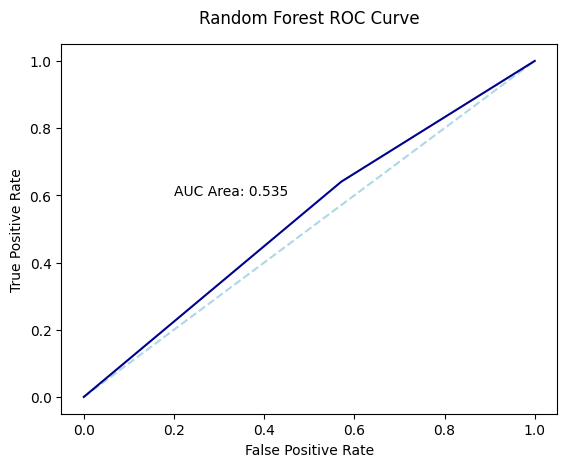



ROC AUC Area:  0.535


In [ ]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--', color = "#ADD8E6")
plt.plot(fpr, tpr, color = "#00008B")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.annotate(f"AUC Area: {roc_auc_score(y_test, y_pred_test).round(3)}", xy = (0.2, 0.6))
plt.title('Random Forest ROC Curve', pad = 15)
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

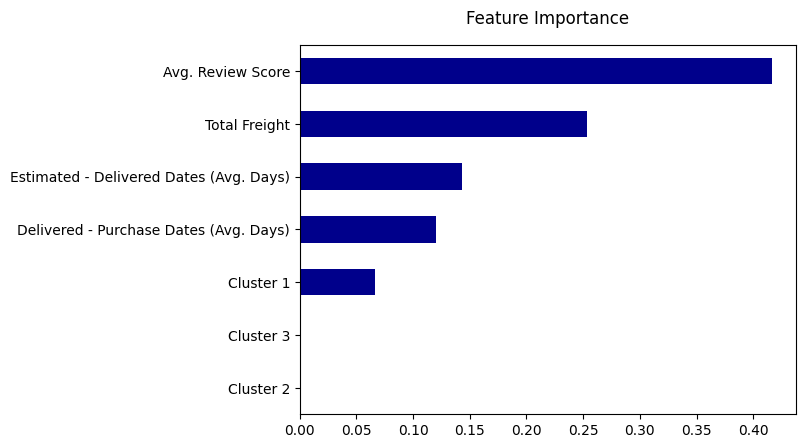

['cat__cluster_1', 'cat__cluster_2', 'cat__cluster_3', 'remainder__avg_del_comp_days', 'remainder__avg_review_score', 'remainder__tt_freight', 'remainder__avg_waiting_days']


In [ ]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

new_names = ['Cluster 1', 'Cluster 2', 'Cluster 3', 'Estimated - Delivered Dates (Avg. Days)', 'Avg. Review Score', 'Total Freight', 'Delivered - Purchase Dates (Avg. Days)']

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = new_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh",
                           color = "#00008B")
plt.title("Feature Importance", pad = 15)
plt.show()

print(feature_names)
feature_names_name = feature_names[0]

## Iteration 3.4.1 (Remove Clusters)

#### Train / Test Split

Define Features and Target

In [ ]:
rf_df.info()

# Removing missing values on review_score
rf_df_dropna = rf_df.dropna(subset = ["avg_review_score"])
rf_df_dropna.info()

# Features
X = rf_df_dropna[["avg_del_comp_days",
           "cluster",
           "avg_review_score",
           "tt_freight",
           "avg_waiting_days"]]

# Target
y = rf_df_dropna["retention"]

<class 'pandas.core.frame.DataFrame'>
Index: 10818 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10818 non-null  object 
 1   retention           10818 non-null  int64  
 2   tt_product_qty      10818 non-null  int64  
 3   tt_freight          10818 non-null  float64
 4   avg_waiting_days    10818 non-null  float64
 5   avg_del_comp_days   10818 non-null  float64
 6   avg_review_score    10738 non-null  float64
 7   purch_d_n           10818 non-null  object 
 8   purch_wd            10818 non-null  object 
 9   pay_type            10818 non-null  object 
 10  sp_rj_mg_or_other   10818 non-null  object 
 11  cluster             10818 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 10738 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dty

Train / Test Split

In [ ]:
# Split the dataset into 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   stratify = y, random_state = seed)


#### Transformations

One-Hot Enconding

In [ ]:
# One-hot encode categorical features for training and test sets separately
# We remove drop = "first"
ohe = OneHotEncoder()

Imputation

In [ ]:
# No numerical imputation

Define Columns

In [ ]:
# Select categorical features
X_cat = X.select_dtypes("O")

Preprocessor

In [ ]:
# This step is needed because we have different kind of imputations for
# categorical and numerical features
# remainder='passthrough' otherwise it will not get the other features
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', ohe, X_cat.columns)],
    remainder='passthrough')

# Remove irrelevant clusters


#### Random Forest Model

In [ ]:
rf = RandomForestClassifier(random_state = seed)

#### Pipeline

In [ ]:
pipeline = Pipeline(
    steps = [
        ("preprocessor", preprocessor),
        ("column_remover", FunctionTransformer(lambda array: pd.DataFrame(array).drop(
            columns = [0, 2, 3]))),
         ("rf_model", rf)])

# Check names to remove the correct index and keep cluster_1
print(pipeline.named_steps['preprocessor'].get_feature_names_out())


# Fit
pipeline.fit(X_train, y_train)


# Predict
y_pred = pipeline.predict(X_test)

['cat__cluster_0' 'cat__cluster_1' 'cat__cluster_2' 'cat__cluster_3'
 'remainder__avg_del_comp_days' 'remainder__avg_review_score'
 'remainder__tt_freight' 'remainder__avg_waiting_days']


##### Evaluating

In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred))
print("\n")

# Classification Report
print(classification_report(y_test, y_pred))
print("\n")

# ROC Curve /AUC
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred).round(3))

[[2079    5]
 [  64    0]]


              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2084
           1       0.00      0.00      0.00        64

    accuracy                           0.97      2148
   macro avg       0.49      0.50      0.49      2148
weighted avg       0.94      0.97      0.95      2148



ROC AUC Area:  0.499


#### CV / RandomnizedSearch

In [ ]:
# Define the grid of hyperparameters
params_rf = {
    'rf_model__n_estimators': [100, 150, 200, 250, 300],
    "rf_model__max_depth": [2, 3, 4, 5, 6, 8],
    "rf_model__min_samples_leaf": [0.2, 0.22, 0.25, 0.27, 0.3],
    "rf_model__max_features": [1, 2, 3, 4, 5],    # not relevant as they are only few
    "rf_model__class_weight": ["balanced", "balanced_subsample", None]}

# Shuffle and split the data
kf = KFold(n_splits = 10, shuffle = True, random_state = seed)

# CV
cv_rf = RandomizedSearchCV(estimator = pipeline,
                             param_distributions = params_rf,
                             scoring = "recall",
                             cv = kf,
                             n_iter = 30,
                             random_state = seed)

# Fit cv_rf to the training set
cv_rf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/compose/_column_transformer.py:1667: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


RandomizedSearchCV(cv=KFold(n_splits=10, random_state=123, shuffle=True),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('cat',
                                                                               OneHotEncoder(),
                                                                               Index(['cluster'], dtype='object'))])),
                                             ('column_remover',
                                              FunctionTransformer(func=<function <lambda> at 0x7f631c507f60>)),
                                             ('rf_model',
                                              RandomForestClassifier(random_state=123))]),
                   n_iter=30,
                   param_distributions={'rf_model__class_weight': ['balanced',
                                                                   'balanced_subsample',
                                                                   None],
                                        'rf_model__max_depth': [2, 3, 4, 5, 6,
                                                                8],
                                        'rf_model__max_features': [1, 2, 3, 4,
                                                                   5],
                                        'rf_model__min_samples_leaf': [0.2,
                                                                       0.22,
                                                                       0.25,
                                                                       0.27,
                                                                       0.3],
                                        'rf_model__n_estimators': [100, 150,
                                                                   200, 250,
                                                                   300]},
                   random_state=123, scoring='recall')

##### Evaluating (CV)

In [ ]:
# Extract best hyperparameters from cv_rf
best_hyperparams = cv_rf.best_params_
print("Best hyerparameters:\n", best_hyperparams)
print("\n")

# Extract best CV score (recall) from cv_rf
best_CV_score = cv_rf.best_score_
print('Best CV score (recall):', best_CV_score.round(3))



Best hyerparameters:
 {'rf_model__n_estimators': 300, 'rf_model__min_samples_leaf': 0.25, 'rf_model__max_features': 4, 'rf_model__max_depth': 8, 'rf_model__class_weight': 'balanced'}


Best CV score (recall): 0.677


#### Evaluating (Test Set)

Accuracy

In [ ]:
# Extract best model from cv_rf
best_model = cv_rf.best_estimator_

# Evaluate test set recall
test_recall = best_model.score(X_test, y_test)
print("Test set accuracy of best model: {:.3f}".format(test_recall))

Test set accuracy of best model: 0.436


Generalization Error

In [ ]:
# Predict of training set
y_pred_train = best_model.predict(X_train)

# Predict of test set
y_pred_test = best_model.predict(X_test)

# CV Recall
print('CV Recall: {:.3f}'.format(best_CV_score))

# Training set Recall
print('Train Recall: {:.3f}'.format(recall_score(y_train, y_pred_train)))

# Test set Recall
print('Test Recall: {:.3f}'.format(recall_score(y_test, y_pred_test)))

CV Recall: 0.677
Train Recall: 0.682
Test Recall: 0.641


Confusion Matrix

[[ 895 1189]
 [  23   41]]




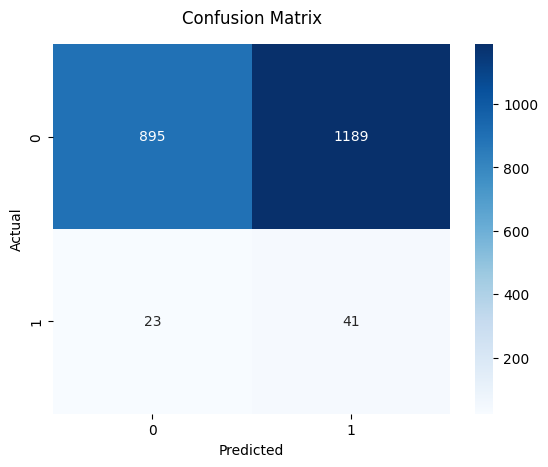

              precision    recall  f1-score   support

           0       0.97      0.43      0.60      2084
           1       0.03      0.64      0.06        64

    accuracy                           0.44      2148
   macro avg       0.50      0.54      0.33      2148
weighted avg       0.95      0.44      0.58      2148



In [ ]:
# Confusion Matrix
print(confusion_matrix(y_test, y_pred_test))
print("\n")

sns.heatmap(confusion_matrix(y_test, y_pred_test),
            annot=True,
            fmt='d',
            cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix', pad = 15)
plt.show()

# Classification Report
print(classification_report(y_test, y_pred_test))



ROC Curve / AUC

<ipython-input-136-4e82e4c75293>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', color = "#ADD8E6")


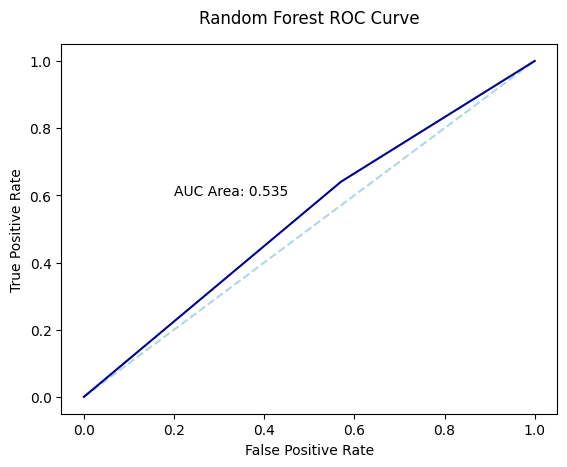



ROC AUC Area:  0.535


In [ ]:
# Plot
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)
plt.plot([0, 1], [0, 1], 'k--', color = "#ADD8E6")
plt.plot(fpr, tpr, color = "#00008B")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.annotate(f"AUC Area: {roc_auc_score(y_test, y_pred_test).round(3)}", xy = (0.2, 0.6))
plt.title('Random Forest ROC Curve', pad = 15)
plt.show()


# ROC AUC area
print("\n")
print("ROC AUC Area: ", roc_auc_score(y_test, y_pred_test).round(3))


#### Feature Importance

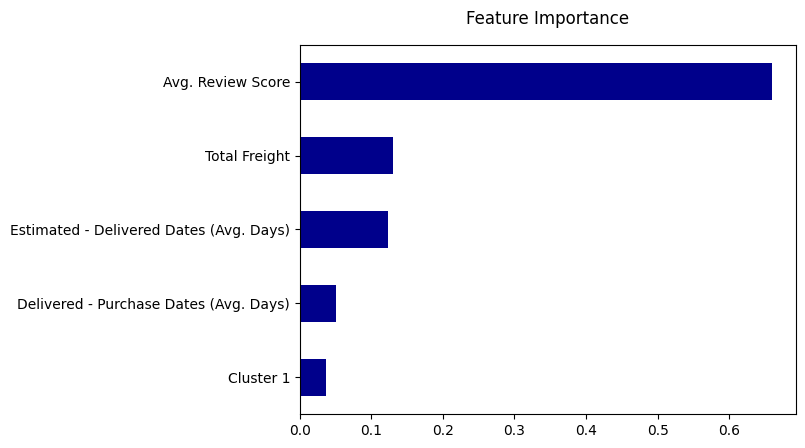

In [ ]:
# Get the best pipeline
best_pipeline = cv_rf.best_estimator_

# Get the RandomForest model from the pipeline
random_forest_model = best_pipeline.named_steps["rf_model"]

# Get feature importances
feature_importances = random_forest_model.feature_importances_

# Get the feature names from the preprocessor's output.
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out().tolist()

new_names = [
    "Cluster 1", "Estimated - Delivered Dates (Avg. Days)",\
    "Avg. Review Score", "Total Freight", "Delivered - Purchase Dates (Avg. Days)"]

# Create a pd.Series for feature importance
feature_importance_rf = pd.Series(
    feature_importances, index = new_names).sort_values()

# Plot
feature_importance_rf.plot(kind = "barh",
                           color = "#00008B")
plt.title("Feature Importance", pad = 15)
plt.show()


## Logistic Regression

### Import File

In [226]:
 # Substitute the file path below with your own file path from 'FINAL-GRUPOIII' folder.
 # The file name is "features_table.csv".
lr_df = pd.read_csv("/content/drive/MyDrive/Projeto1/Samba_Lovers/Project_I/APRESENTAÇÃO/FINAL-GRUPOIII/features_table.csv")

#set seed
seed = 123

In [227]:
# Change cluster type
lr_df["cluster"] = lr_df["cluster"].astype("O")

# Inspect
lr_df.info()
lr_df.isna().sum()

lr_df = lr_df[lr_df["pay_type"] != "0"]

lr_df["pay_type"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10819 entries, 0 to 10818
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_unique_id  10819 non-null  object 
 1   retention           10819 non-null  int64  
 2   tt_product_qty      10819 non-null  int64  
 3   tt_freight          10819 non-null  float64
 4   avg_waiting_days    10819 non-null  float64
 5   avg_del_comp_days   10819 non-null  float64
 6   avg_review_score    10739 non-null  float64
 7   purch_d_n           10819 non-null  object 
 8   purch_wd            10819 non-null  object 
 9   pay_type            10819 non-null  object 
 10  sp_rj_mg_or_other   10819 non-null  object 
 11  cluster             10819 non-null  object 
dtypes: float64(4), int64(2), object(6)
memory usage: 1014.4+ KB


pay_type
credit_card    8142
boleto         2334
voucher         237
debit_card      105
Name: count, dtype: int64

### Iteration 1 (Cross-Validation)



#### Features & Pipeline Creation

In [228]:
# Define numerical and categorical columns
numeric_features = ["tt_product_qty", "tt_freight", "avg_waiting_days", "avg_review_score"]
categorical_features = ["purch_d_n", "purch_wd", "pay_type", "sp_rj_mg_or_other", "cluster"]

In [229]:
# Creation ColumnTransformer to handle numeroc and categorical columns separately
preprocessor_mean = ColumnTransformer(
    transformers=[
        #Numeric pipeline: Impute missing values with mean, then scale
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        # Categorical pipeline: Only encode ( no imputation needed since there are no missing values)
        ("cat", Pipeline([
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) #handles unknown categories by setting their encoded values to all zeros
        ]), categorical_features)
    ]
)

In [230]:
#Logistic Regression Model w/class_weight="balanced"
model_balanced = LogisticRegression(random_state=seed, max_iter=250, class_weight="balanced")

#Create a Pipeline with the balanced model
pipeline_balanced_mean = Pipeline([
    ("preprocessor", preprocessor_mean),
    ("classifier", model_balanced)
])

#### Train-Test Split

In [231]:
# Creation of features
X = lr_df[numeric_features + categorical_features]
y = lr_df["retention"]

# Train-test split (80%/20%) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

#Fit the Pipeline
pipeline_balanced_mean.fit(X_train, y_train)

# Get predicted class labels for evaluation
y_pred_balanced_mean = pipeline_balanced_mean.predict(X_test)

#### Cross-Validation Test

In [232]:
#Cross-Validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

#Define Scoring metrics
scoring = {
    "roc_auc": "roc_auc",
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
    "f1": make_scorer(f1_score, pos_label=1)
}

# Performe Cross-Validation
cv_results = cross_validate(pipeline_balanced_mean, X, y, cv=cv, scoring=scoring, return_train_score=False)

#Print the CV results
print("Cross-Validation Results (5-Fold):")
print(f"AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std() * 2:.4f})")
print(f"Precision (Retention): {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std() * 2:.4f})")
print(f"Recall (Retention): {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std() * 2:.4f})")
print(f"F1-Score (Retention): {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std() * 2:.4f})")

Cross-Validation Results (5-Fold):
AUC: 0.5616 (+/- 0.0904)
Precision (Retention): 0.0380 (+/- 0.0104)
Recall (Retention): 0.4938 (+/- 0.1263)
F1-Score (Retention): 0.0706 (+/- 0.0187)


##### Evaluation

In [233]:
# Evaluate the model
print("Model Accuracy (Test Set):", pipeline_balanced_mean.score(X_test, y_test))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced_mean))
print("Classification Report:")
print(classification_report(y_test, y_pred_balanced_mean, target_names=["No Retention", "Retention"]))
cm_balanced = (confusion_matrix(y_test, y_pred_balanced_mean))

Model Accuracy (Test Set): 0.6178373382624769
Confusion Matrix:
[[1307  792]
 [  35   30]]
Classification Report:
              precision    recall  f1-score   support

No Retention       0.97      0.62      0.76      2099
   Retention       0.04      0.46      0.07        65

    accuracy                           0.62      2164
   macro avg       0.51      0.54      0.41      2164
weighted avg       0.95      0.62      0.74      2164



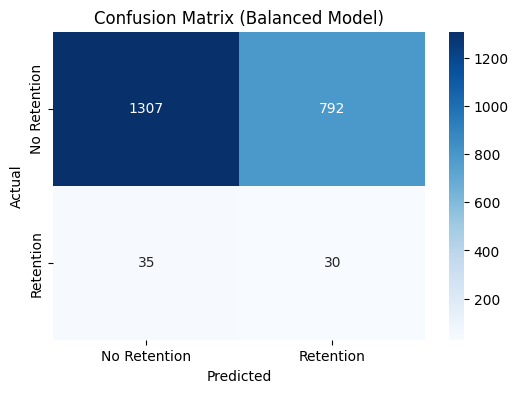

In [234]:
#Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=["No Retention", "Retention"], yticklabels=["No Retention", "Retention"])
plt.title("Confusion Matrix (Balanced Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Feature Importance Analysis

In [235]:
#Compute permutation importance on the test set
perm_importance = permutation_importance(pipeline_balanced_mean, X_test, y_test, scoring="roc_auc", n_repeats=10, random_state=seed)

# Get the transformed feature names for categorical features (after OneHotEncoder)
cat_transformer = pipeline_balanced_mean.named_steps['preprocessor'].named_transformers_['cat']
cat_encoder = cat_transformer.named_steps['encoder']
categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Combine numeric and categorical feature names
features = np.concatenate([numeric_features, categorical_feature_names])

# Ensure the features list matches the length of perm_importance.importances_mean
if len(features) != len(perm_importance.importances_mean):
    print(f"Warning: Length mismatch - features: {len(features)}, importances: {len(perm_importance.importances_mean)}")
    features = features[:len(perm_importance.importances_mean)]

In [236]:
# DataFrame of feature names and their importance
perm_importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": perm_importance.importances_mean,
    "Std": perm_importance.importances_std
})

# Sort by Importance
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)

print("Feature Importance (Permutation Importance):")
print(perm_importance_df)

Feature Importance (Permutation Importance):
             Feature  Importance       Std
8    pay_type_boleto    0.043298  0.011224
3   avg_review_score    0.016727  0.016688
6  purch_wd_weekdays    0.010151  0.008332
7   purch_wd_weekend    0.003910  0.003365
5    purch_d_n_night    0.002301  0.005832
2   avg_waiting_days    0.001755  0.003622
1         tt_freight   -0.000163  0.002234
4      purch_d_n_day   -0.000767  0.015241
0     tt_product_qty   -0.015737  0.011392


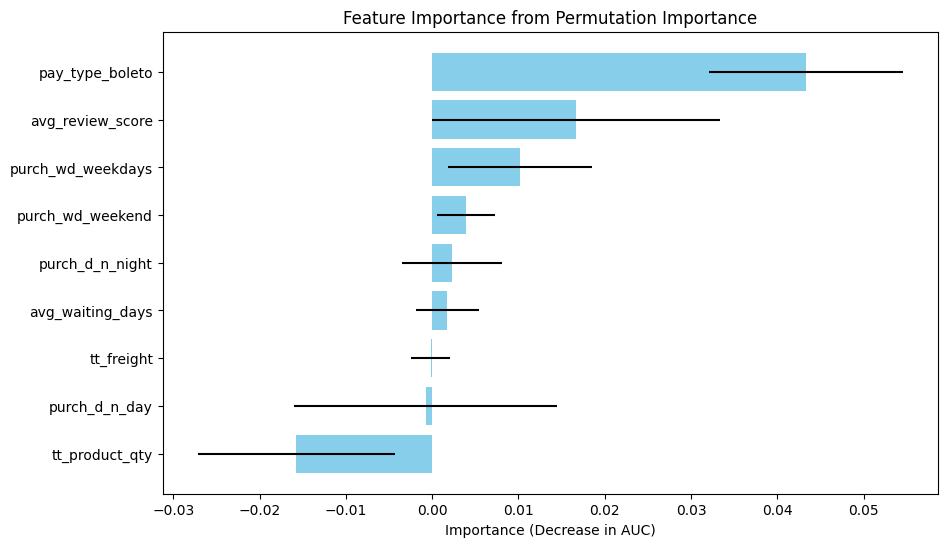

In [237]:
#Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df["Feature"], perm_importance_df["Importance"], xerr=perm_importance_df["Std"], color="skyblue")
plt.xlabel("Importance (Decrease in AUC)")
plt.title("Feature Importance from Permutation Importance")
plt.gca().invert_yaxis()
plt.show()

####ROC Curve

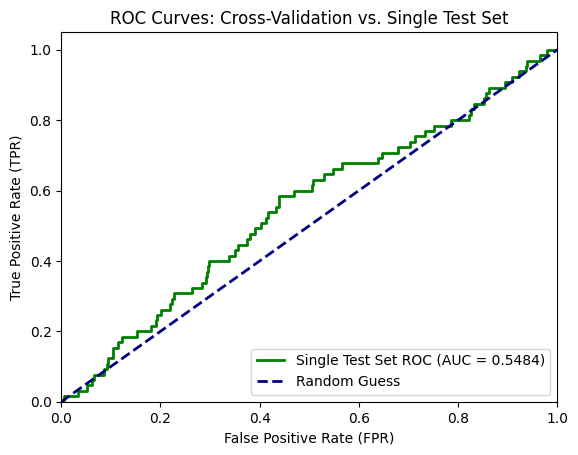

Single Test Set AUC: 0.5484


In [238]:
# Get predicted probabilities for the test set (for ROC curve)
y_pred_prob = pipeline_balanced_mean.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# Single test set ROC curve
plt.plot(fpr, tpr, color="green", lw=2, label=f"Single Test Set ROC (AUC = {roc_auc:.4f})")
# Random guess line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves: Cross-Validation vs. Single Test Set")
plt.legend(loc="lower right")
plt.show()

# Print the Single Test Set AUC

print(f"Single Test Set AUC: {roc_auc:.4f}")

### Iteration 2 (CV - Median)



#### Features & Pipeline Creation

In [239]:
# Define numerical and categorical columns
numeric_features = ["tt_product_qty", "tt_freight", "avg_waiting_days", "avg_review_score"]
categorical_features = ["purch_d_n", "purch_wd", "pay_type", "sp_rj_mg_or_other", "cluster"]

In [240]:
# Creation ColumnTransformer to handle numeroc and categorical columns separately
preprocessor_median = ColumnTransformer(
    transformers=[
        #Numeric pipeline: Impute missing values with mean, then scale
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        # Categorical pipeline: Only encode ( no imputation needed since there are no missing values)
        ("cat", Pipeline([
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) #handles unknown categories by setting their encoded values to all zeros
        ]), categorical_features)
    ]
)

In [241]:
#Logistic Regression Model
model_balanced = LogisticRegression(random_state=seed, max_iter=250, class_weight="balanced")

#Create a Pipeline with the balanced model
pipeline_balanced_median = Pipeline([
    ("preprocessor", preprocessor_median),
    ("classifier", model_balanced)
])

#### Train-Test Split

In [242]:
# Creation of features
X = lr_df[numeric_features + categorical_features]
y = lr_df["retention"]

# Train-test split (80%/20%) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

#Fit the Pipeline
pipeline_balanced_median.fit(X_train, y_train)

# Get predicted class labels for evaluation
y_pred_balanced_median = pipeline_balanced_median.predict(X_test)

#### Cross-Validation Test

In [243]:
#Cross-Validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

#Define Scoring metrics
scoring = {
    "roc_auc": "roc_auc",
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
    "f1": make_scorer(f1_score, pos_label=1)
}

# Performe Cross-Validation
cv_results = cross_validate(pipeline_balanced_median, X, y, cv=cv, scoring=scoring, return_train_score=False)

#Print the results
print("Cross-Validation Results (5-Fold):")
print(f"AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std() * 2:.4f})")
print(f"Precision (Retention): {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std() * 2:.4f})")
print(f"Recall (Retention): {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std() * 2:.4f})")
print(f"F1-Score (Retention): {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std() * 2:.4f})")

Cross-Validation Results (5-Fold):
AUC: 0.5617 (+/- 0.0908)
Precision (Retention): 0.0380 (+/- 0.0105)
Recall (Retention): 0.4938 (+/- 0.1263)
F1-Score (Retention): 0.0706 (+/- 0.0188)


##### Evaluation

In [244]:
# Evaluate the model
print("Balanced Model Accuracy (Test Set):", pipeline_balanced_median.score(X_test, y_test))
print("Balanced Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_balanced_median))
print("Balanced Classification Report:")
print(classification_report(y_test, y_pred_balanced_median, target_names=["No Retention", "Retention"]))
cm_balanced = (confusion_matrix(y_test, y_pred_balanced_median))

Balanced Model Accuracy (Test Set): 0.6187615526802218
Balanced Confusion Matrix:
[[1309  790]
 [  35   30]]
Balanced Classification Report:
              precision    recall  f1-score   support

No Retention       0.97      0.62      0.76      2099
   Retention       0.04      0.46      0.07        65

    accuracy                           0.62      2164
   macro avg       0.51      0.54      0.41      2164
weighted avg       0.95      0.62      0.74      2164



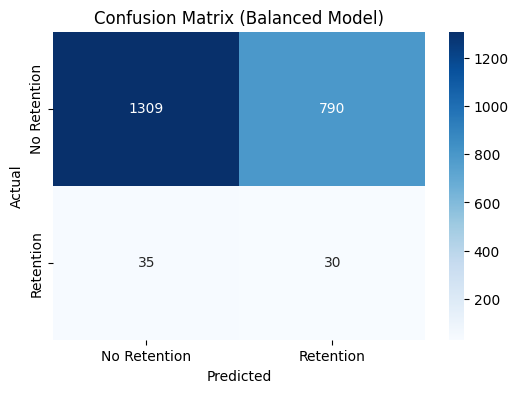

In [245]:
#Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=["No Retention", "Retention"], yticklabels=["No Retention", "Retention"])
plt.title("Confusion Matrix (Balanced Model)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Comparison between Mean vs Median

In [246]:
#Accuracy Score Comparison
accuracy_mean = accuracy_score(y_test, y_pred_balanced_mean)
accuracy_median = accuracy_score(y_test, y_pred_balanced_median)

# Compute accuracy
print("### Accuracy")
print(f"Mean Imputation Accuracy: {accuracy_mean:.4f}")
print(f"Median Imputation Accuracy: {accuracy_median:.4f}")
print(f"Difference (Median - Mean): {(accuracy_median - accuracy_mean):.4f}\n")

# Compute confusion matrices
cm_mean = confusion_matrix(y_test, y_pred_balanced_mean)
cm_median = confusion_matrix(y_test, y_pred_balanced_median)

# Compute classification reports as dictionaries
report_mean = classification_report(y_test, y_pred_balanced_mean, target_names=["No Retention", "Retention"], output_dict=True)
report_median = classification_report(y_test, y_pred_balanced_median, target_names=["No Retention", "Retention"], output_dict=True)

# Compute ROC AUC
roc_auc_mean = roc_auc_score(y_test, y_pred_balanced_mean)
roc_auc_median = roc_auc_score(y_test, y_pred_balanced_median)

# Print Results
print("## Comparison of Mean vs. Median Imputation\n")

# Accuracy
print("### Accuracy")
print(f"Mean Imputation Accuracy: {accuracy_mean:.4f}")
print(f"Median Imputation Accuracy: {accuracy_median:.4f}")
print(f"Difference (Median - Mean): {(accuracy_median - accuracy_mean):.4f}\n")

# Confusion Matrices
print("### Confusion Matrices")
print("Mean Imputation Confusion Matrix:")
print(cm_mean)
print("\nMedian Imputation Confusion Matrix:")
print(cm_median)
print("\nDifference (Median - Mean):")
print(cm_median - cm_mean)

# Classification Report Comparison
print("### Classification Report Comparison")
print("#### Retention")
print(f"Precision (Mean): {report_mean['Retention']['precision']:.2f}")
print(f"Precision (Median): {report_median['Retention']['precision']:.2f}")
print(f"Difference (Median - Mean): {(report_median['Retention']['precision'] - report_mean['Retention']['precision']):+.2f}")
print(f"Recall (Mean): {report_mean['Retention']['recall']:.2f}")
print(f"Recall (Median): {report_median['Retention']['recall']:.2f}")
print(f"Difference (Median - Mean): {(report_median['Retention']['recall'] - report_mean['Retention']['recall']):+.2f}")
print(f"F1-Score (Mean): {report_mean['Retention']['f1-score']:.2f}")
print(f"F1-Score (Median): {report_median['Retention']['f1-score']:.2f}")
print(f"Difference (Median - Mean): {(report_median['Retention']['f1-score'] - report_mean['Retention']['f1-score']):+.2f}\n")


### Accuracy
Mean Imputation Accuracy: 0.6178
Median Imputation Accuracy: 0.6188
Difference (Median - Mean): 0.0009

## Comparison of Mean vs. Median Imputation

### Accuracy
Mean Imputation Accuracy: 0.6178
Median Imputation Accuracy: 0.6188
Difference (Median - Mean): 0.0009

### Confusion Matrices
Mean Imputation Confusion Matrix:
[[1307  792]
 [  35   30]]

Median Imputation Confusion Matrix:
[[1309  790]
 [  35   30]]

Difference (Median - Mean):
[[ 2 -2]
 [ 0  0]]
### Classification Report Comparison
#### Retention
Precision (Mean): 0.04
Precision (Median): 0.04
Difference (Median - Mean): +0.00
Recall (Mean): 0.46
Recall (Median): 0.46
Difference (Median - Mean): +0.00
F1-Score (Mean): 0.07
F1-Score (Median): 0.07
Difference (Median - Mean): +0.00



#### Feature Importance Analysis

In [247]:
#Compute permutation importance on the test set
perm_importance = permutation_importance(pipeline_balanced_median, X_test, y_test, scoring="roc_auc", n_repeats=10, random_state=seed)

# Get the transformed feature names for categorical features (after OneHotEncoder)
cat_transformer = pipeline_balanced_median.named_steps['preprocessor'].named_transformers_['cat']
cat_encoder = cat_transformer.named_steps['encoder']
categorical_feature_names = cat_encoder.get_feature_names_out(categorical_features)

# Combine numeric and categorical feature names
features = np.concatenate([numeric_features, categorical_feature_names])

# Ensure the features list matches the length of perm_importance.importances_mean
if len(features) != len(perm_importance.importances_mean):
    print(f"Warning: Length mismatch - features: {len(features)}, importances: {len(perm_importance.importances_mean)}")
    features = features[:len(perm_importance.importances_mean)]

In [248]:
# DataFrame of feature names and their importance
perm_importance_df = pd.DataFrame({
    "Feature": features,
    "Importance": perm_importance.importances_mean,
    "Std": perm_importance.importances_std
})

# Sort by Importance
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)

print("Feature Importance (Permutation Importance):")
print(perm_importance_df)

Feature Importance (Permutation Importance):
             Feature  Importance       Std
8    pay_type_boleto    0.043210  0.011153
3   avg_review_score    0.015909  0.016684
6  purch_wd_weekdays    0.010266  0.008325
7   purch_wd_weekend    0.004082  0.003416
5    purch_d_n_night    0.002646  0.005913
2   avg_waiting_days    0.001868  0.003708
1         tt_freight   -0.000220  0.002353
4      purch_d_n_day   -0.000668  0.015233
0     tt_product_qty   -0.015884  0.011374


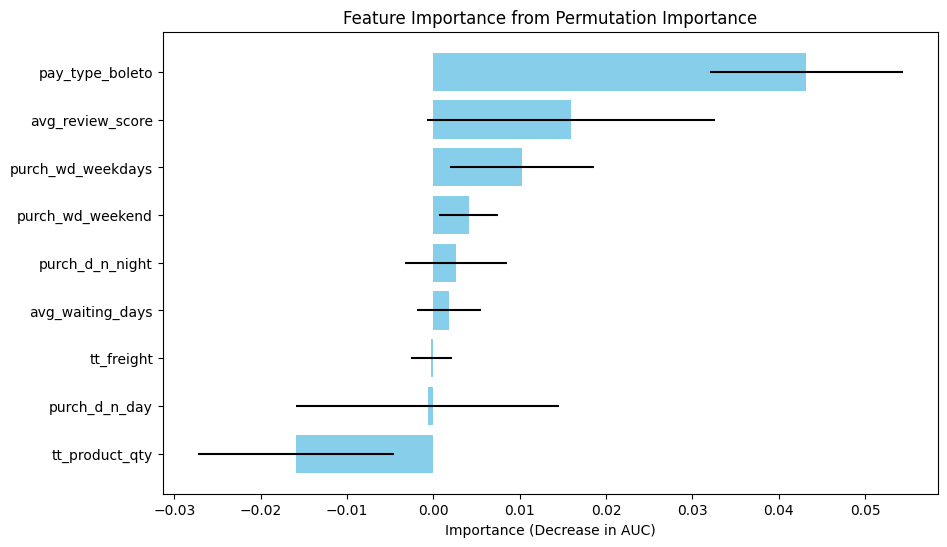

In [249]:
#Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(perm_importance_df["Feature"], perm_importance_df["Importance"], xerr=perm_importance_df["Std"], color="skyblue")
plt.xlabel("Importance (Decrease in AUC)")
plt.title("Feature Importance from Permutation Importance")
plt.gca().invert_yaxis()
plt.show()

####ROC Curve

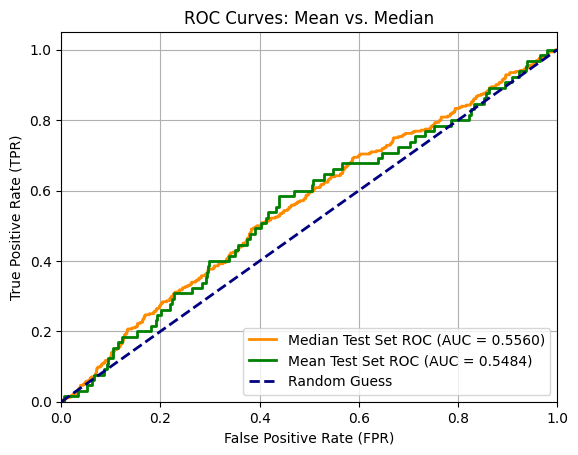

Mean AUC: 0.5560
Median AUC: 0.5484


In [250]:
# Get predicted probabilities Mean Imputer for the test set (for ROC curve)
y_pred_prob_mean = pipeline_balanced_mean.predict_proba(X_test)[:, 1]

# Cross-validated predicted probabilities Median Imputer for the entire dataset
y_pred_prob_median = cross_val_predict(pipeline_balanced_median, X, y, cv=cv, method="predict_proba")[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

# Compute the ROC curve and AUC for the cross-validated predictions
fpr_median, tpr_median, thresholds_median = roc_curve(y, y_pred_prob_median, pos_label=1)
roc_auc_median = auc(fpr_median, tpr_median)

# Median Imputer ROC curve
plt.plot(fpr_median, tpr_median, color="darkorange", lw=2, label=f"Median Test Set ROC (AUC = {roc_auc_median:.4f})")

# Single test set ROC curve
plt.plot(fpr, tpr, color="green", lw=2, label=f"Mean Test Set ROC (AUC = {roc_auc:.4f})")

# Random guess line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves: Mean vs. Median")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print the AUCs for clarity
print(f"Mean AUC: {roc_auc_median:.4f}")
print(f"Median AUC: {roc_auc:.4f}")

### Iteration 3 (Hyperparameterization)



#### Features & Pipeline Creation

In [251]:
# Define numerical and categorical columns
numeric_features = ["tt_product_qty", "tt_freight", "avg_waiting_days", "avg_review_score"]
categorical_features = ["purch_d_n", "purch_wd", "pay_type", "sp_rj_mg_or_other", "cluster"]

In [252]:
# Creation ColumnTransformer to handle numeroc and categorical columns separately
preprocessor_median = ColumnTransformer(
    transformers=[
        #Numeric pipeline: Impute missing values with Median, then scale
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), numeric_features),
        # Categorical pipeline: Only encode ( no imputation needed since there are no missing values)
        ("cat", Pipeline([
            ("encoder", OneHotEncoder(handle_unknown="ignore", sparse_output=False)) #handles unknown categories by setting their encoded values to all zeros
        ]), categorical_features)
    ]
)

In [253]:
#Logistic Regression Model
model_balanced = LogisticRegression(random_state=seed, max_iter=250, class_weight="balanced")

#Create a Pipeline with the balanced model
pipeline_balanced_median = Pipeline([
    ("preprocessor", preprocessor_median),
    ("classifier", model_balanced)
])

#### Train-Test Split

In [254]:
# Creation of features
X = lr_df[numeric_features + categorical_features]
y = lr_df["retention"]

# Train-test split (80%/20%) with stratification
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=seed,
                                                    stratify=y)

#### CV RandomizedSearch Test

In [255]:
# Define hyperparameter grid
param_grid = [
    {
        "classifier__solver": ["liblinear"],
        "classifier__penalty": ["l1", "l2"],
        "classifier__C": [0.001, 0.01, 0.1, 1, 10],
        "classifier__class_weight": ["balanced", {0:1, 1:10}, {0:1, 1:20}]
    },
    {
        "classifier__solver": ["lbfgs"],
        "classifier__penalty": ["l2"],
        "classifier__C": [0.001, 0.01, 0.1, 1, 10],
        "classifier__class_weight": ["balanced", {0:1, 1:10}, {0:1, 1:20}]
    }
]

# Cross-validation strategy for hyperparameter tuning
cv_tune = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline_balanced_median,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings to sample
    scoring="recall",  # Optimize for recall of Retention class
    cv=cv_tune,
    random_state=seed,
    n_jobs=-1  # Use all available cores
)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Print the best parameters and score
print("Best Hyperparameters:", random_search.best_params_)
print("Best Cross-Validation Recall (Retention):", random_search.best_score_.round(4))

# Get the best model
best_pipeline = random_search.best_estimator_

Best Hyperparameters: {'classifier__solver': 'liblinear', 'classifier__penalty': 'l1', 'classifier__class_weight': 'balanced', 'classifier__C': 0.01}
Best Cross-Validation Recall (Retention): 0.629


#### CV Test with the Best Model

In [256]:
# Cross-Validation Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

# Define Scoring metrics
scoring = {
    "roc_auc": "roc_auc",
    "precision": make_scorer(precision_score, pos_label=1),
    "recall": make_scorer(recall_score, pos_label=1),
    "f1": make_scorer(f1_score, pos_label=1)
}

# Perform Cross-Validation with the best model
cv_results = cross_validate(best_pipeline, X, y, cv=cv, scoring=scoring, return_train_score=False)

# Print the results
print("\nCross-Validation Results (5-Fold) with Best Model:")
print(f"AUC: {cv_results['test_roc_auc'].mean():.4f} (+/- {cv_results['test_roc_auc'].std() * 2:.4f})")
print(f"Precision (Retention): {cv_results['test_precision'].mean():.4f} (+/- {cv_results['test_precision'].std() * 2:.4f})")
print(f"Recall (Retention): {cv_results['test_recall'].mean():.4f} (+/- {cv_results['test_recall'].std() * 2:.4f})")
print(f"F1-Score (Retention): {cv_results['test_f1'].mean():.4f} (+/- {cv_results['test_f1'].std() * 2:.4f})")


Cross-Validation Results (5-Fold) with Best Model:
AUC: 0.5592 (+/- 0.0943)
Precision (Retention): 0.0344 (+/- 0.0105)
Recall (Retention): 0.6049 (+/- 0.2895)
F1-Score (Retention): 0.0650 (+/- 0.0203)


##### Evaluation

In [257]:
# Evaluate the model
print("\nBalanced Model Accuracy (Test Set):", best_pipeline.score(X_test, y_test))
print("Balanced Confusion Matrix:")
cm_balanced = confusion_matrix(y_test, y_pred_balanced_median)
print(cm_balanced)
print("Balanced Classification Report:")
print(classification_report(y_test, y_pred_balanced_median, target_names=["No Retention", "Retention"]))


Balanced Model Accuracy (Test Set): 0.533271719038817
Balanced Confusion Matrix:
[[1309  790]
 [  35   30]]
Balanced Classification Report:
              precision    recall  f1-score   support

No Retention       0.97      0.62      0.76      2099
   Retention       0.04      0.46      0.07        65

    accuracy                           0.62      2164
   macro avg       0.51      0.54      0.41      2164
weighted avg       0.95      0.62      0.74      2164



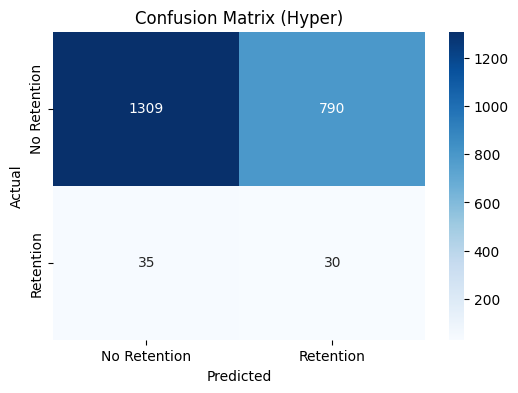

In [258]:
# Visualize confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_balanced, annot=True, fmt="d", cmap="Blues", xticklabels=["No Retention", "Retention"], yticklabels=["No Retention", "Retention"])
plt.title("Confusion Matrix (Hyper)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

#### Feature Importance Analysis with Best Model

In [259]:
# Compute permutation importance on the test set
perm_importance = permutation_importance(best_pipeline, X_test, y_test, scoring="roc_auc", n_repeats=10, random_state=seed)

# Get the transformed feature names directly from the preprocessor
feature_names = best_pipeline.named_steps["preprocessor"].get_feature_names_out()

# Ensure the feature names match the length of perm_importance.importances_mean
if len(feature_names) != len(perm_importance.importances_mean):
    print(f"Warning: Length mismatch - feature_names: {len(feature_names)}, importances: {len(perm_importance.importances_mean)}")
    feature_names = feature_names[:len(perm_importance.importances_mean)]

In [260]:
# DataFrame of feature names and their importance
perm_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance.importances_mean,
    "Std": perm_importance.importances_std
})

# Sort by Importance
perm_importance_df = perm_importance_df.sort_values(by="Importance", ascending=False)

print("\nFeature Importance (Permutation Importance):")
print(perm_importance_df)


Feature Importance (Permutation Importance):
                  Feature  Importance       Std
8    cat__pay_type_boleto    0.054925  0.018110
3   num__avg_review_score    0.029502  0.028385
6  cat__purch_wd_weekdays    0.003892  0.002334
4      cat__purch_d_n_day    0.001660  0.007794
1         num__tt_freight    0.000000  0.000000
5    cat__purch_d_n_night    0.000000  0.000000
2   num__avg_waiting_days    0.000000  0.000000
7   cat__purch_wd_weekend    0.000000  0.000000
0     num__tt_product_qty   -0.010577  0.009094


In [261]:
#Filtering by positive values
positive_features_df = perm_importance_df[perm_importance_df["Importance"] >= 0]
print("\nFeatures with Positive Importance:")
print(positive_features_df)


Features with Positive Importance:
                  Feature  Importance       Std
8    cat__pay_type_boleto    0.054925  0.018110
3   num__avg_review_score    0.029502  0.028385
6  cat__purch_wd_weekdays    0.003892  0.002334
4      cat__purch_d_n_day    0.001660  0.007794
1         num__tt_freight    0.000000  0.000000
5    cat__purch_d_n_night    0.000000  0.000000
2   num__avg_waiting_days    0.000000  0.000000
7   cat__purch_wd_weekend    0.000000  0.000000


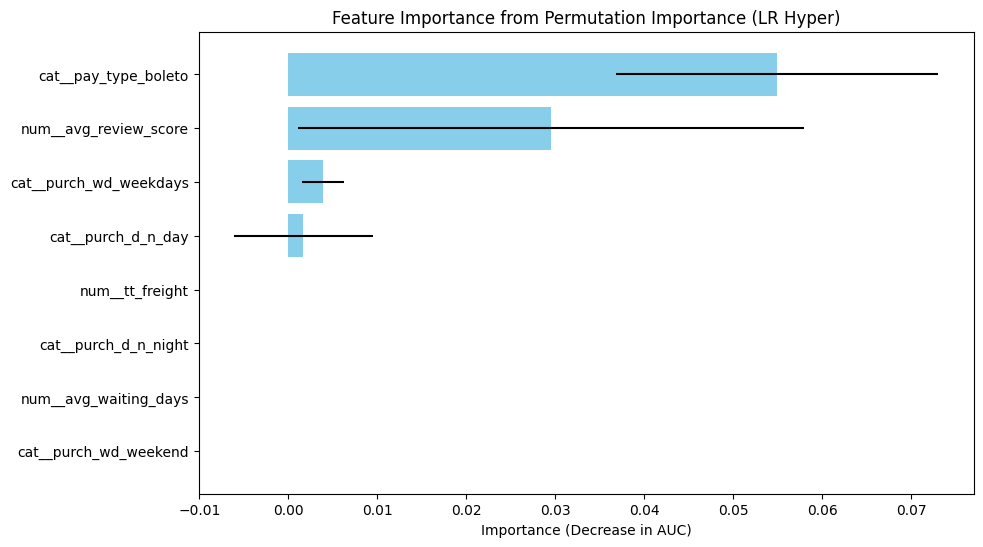

In [262]:
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(positive_features_df["Feature"], positive_features_df["Importance"], xerr=positive_features_df["Std"], color="skyblue")
plt.xlabel("Importance (Decrease in AUC)")
plt.title("Feature Importance from Permutation Importance (LR Hyper)")
plt.gca().invert_yaxis()
plt.show()

#### Recall Values

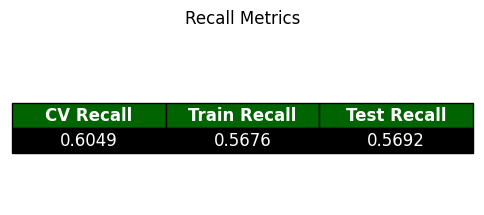

In [263]:
# Predict on test set with the best model
y_pred_best = best_pipeline.predict(X_test)

# Compute Train Recall (fit on training data and predict on training data)
best_pipeline.fit(X_train, y_train)
y_pred_train = best_pipeline.predict(X_train)
train_recall = recall_score(y_train, y_pred_train, pos_label=1)

# Compute Test Recall
test_recall = recall_score(y_test, y_pred_best, pos_label=1)

# CV Recall (already computed in cv_results)
cv_recall = cv_results['test_recall'].mean()

#
fig, ax = plt.subplots(figsize=(6, 2))
ax.axis('off')
table_data = [
    ["CV Recall", "Train Recall", "Test Recall"],
    [f"{cv_recall:.4f}", f"{train_recall:.4f}", f"{test_recall:.4f}"]
]
table = ax.table(cellText=table_data, cellLoc='center', loc='center', colWidths=[0.33, 0.33, 0.33])
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.5)
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('darkgreen')
        cell.set_text_props(color='white', weight='bold')
    else:
        cell.set_facecolor('black')
        cell.set_text_props(color='white')
plt.title("Recall Metrics", pad=20)
plt.savefig("recall_metrics_table.png", bbox_inches='tight', dpi=300)
plt.show()

#### ROC Curve with Best Model

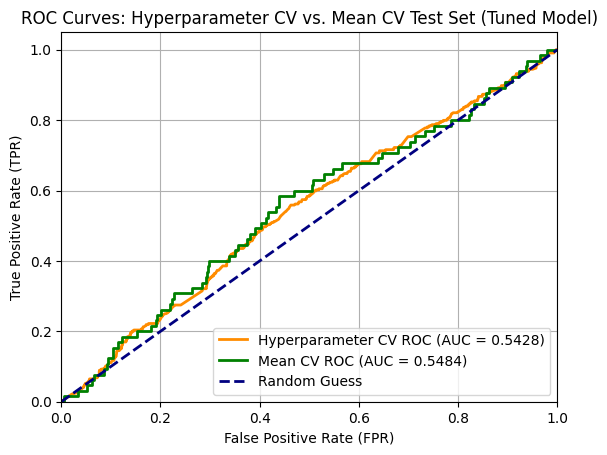

Hyperparameter CV AUC: 0.5428
Single Test Set AUC: 0.5484


In [264]:
# Get predicted probabilities for the test set (for ROC curve)
y_pred_prob = best_pipeline.predict_proba(X_test)[:, 1]

# Hyperparameterization predicted probabilities for the entire dataset
y_pred_prob_hyper = cross_val_predict(best_pipeline, X, y, cv=cv, method="predict_proba")[:, 1]

# Compute Mean Imputer ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_mean, pos_label=1)
roc_auc = auc(fpr, tpr)

# Compute the ROC curve and AUC for the Hyperparameterization predictions
fpr_hyper, tpr_hyper, thresholds_hyper = roc_curve(y, y_pred_prob_hyper, pos_label=1)
roc_auc_hyper = auc(fpr_hyper, tpr_hyper)

# Cross-validation ROC curve
plt.plot(fpr_hyper, tpr_hyper, color="darkorange", lw=2, label=f"Hyperparameter CV ROC (AUC = {roc_auc_hyper:.4f})")

# Single test set ROC curve
plt.plot(fpr, tpr, color="green", lw=2, label=f"Mean CV ROC (AUC = {roc_auc:.4f})")

# Random guess line
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="Random Guess")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves: Hyperparameter CV vs. Mean CV Test Set (Tuned Model)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Print the AUCs for clarity
print(f"Hyperparameter CV AUC: {roc_auc_hyper:.4f}")
print(f"Single Test Set AUC: {roc_auc:.4f}")